# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data2'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

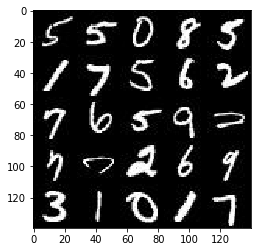

In [2]:
import helper

show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images,'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

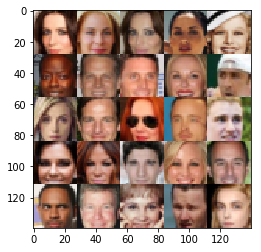

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32, name='learn_rate')
    return inputs_real, inputs_z, learn_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/local/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/local/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'F

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [14]:
def discriminator(images, reuse=False, alpha = 0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x32
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # flatten
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        
        # fully connected
        x1 = tf.layers.dense(z, 2*2*512)
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 16x16x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 32x32x3
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # updated after review
    # add label smoothing to discriminator
    smooth = 0.1
    d_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1.0 - smooth))
    d_loss_real = tf.reduce_mean(d_loss_real)

        
    d_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake))
    d_loss_fake = tf.reduce_mean(d_loss_fake)
    
    g_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake))
    g_loss = tf.reduce_mean(g_loss)
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(ops):
        t_vars = tf.trainable_variables()
        
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]

        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    show_every = 50
    print_every = 10
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.6087... Generator Loss: 1.5565
Epoch 0/2... Discriminator Loss: 0.3872... Generator Loss: 4.5651
Epoch 0/2... Discriminator Loss: 0.4676... Generator Loss: 7.2550
Epoch 0/2... Discriminator Loss: 2.7740... Generator Loss: 15.9740


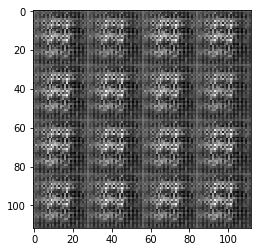

Epoch 0/2... Discriminator Loss: 0.7163... Generator Loss: 10.0083
Epoch 0/2... Discriminator Loss: 0.9806... Generator Loss: 9.3031
Epoch 0/2... Discriminator Loss: 0.5437... Generator Loss: 2.7082
Epoch 0/2... Discriminator Loss: 0.5954... Generator Loss: 1.9688
Epoch 0/2... Discriminator Loss: 0.5677... Generator Loss: 2.2729


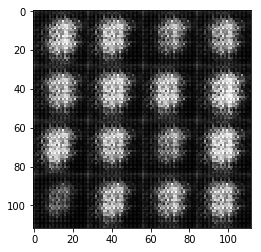

Epoch 0/2... Discriminator Loss: 0.6558... Generator Loss: 1.7695
Epoch 0/2... Discriminator Loss: 0.8893... Generator Loss: 1.0826
Epoch 0/2... Discriminator Loss: 0.5212... Generator Loss: 3.0306
Epoch 0/2... Discriminator Loss: 0.4693... Generator Loss: 2.8920
Epoch 0/2... Discriminator Loss: 0.4273... Generator Loss: 3.7764


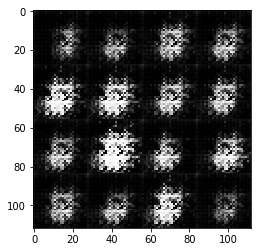

Epoch 0/2... Discriminator Loss: 0.4061... Generator Loss: 2.9887
Epoch 0/2... Discriminator Loss: 0.4258... Generator Loss: 3.0446
Epoch 0/2... Discriminator Loss: 0.4046... Generator Loss: 3.9068
Epoch 0/2... Discriminator Loss: 0.3973... Generator Loss: 4.7210
Epoch 0/2... Discriminator Loss: 0.3853... Generator Loss: 4.0513


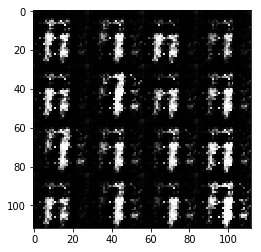

Epoch 0/2... Discriminator Loss: 0.4361... Generator Loss: 2.7624
Epoch 0/2... Discriminator Loss: 0.4982... Generator Loss: 2.1625
Epoch 0/2... Discriminator Loss: 0.4870... Generator Loss: 2.4512
Epoch 0/2... Discriminator Loss: 0.4151... Generator Loss: 3.4704
Epoch 0/2... Discriminator Loss: 0.5724... Generator Loss: 2.0612


Epoch 0/2... Discriminator Loss: 1.0361... Generator Loss: 0.9305
Epoch 0/2... Discriminator Loss: 1.2638... Generator Loss: 6.0858
Epoch 0/2... Discriminator Loss: 0.6868... Generator Loss: 1.8309
Epoch 0/2... Discriminator Loss: 0.5639... Generator Loss: 3.9433
Epoch 0/2... Discriminator Loss: 0.5726... Generator Loss: 2.0408


Epoch 0/2... Discriminator Loss: 0.4548... Generator Loss: 3.0512
Epoch 0/2... Discriminator Loss: 0.5395... Generator Loss: 4.3365
Epoch 0/2... Discriminator Loss: 0.4539... Generator Loss: 2.6819
Epoch 0/2... Discriminator Loss: 0.5964... Generator Loss: 4.9482
Epoch 0/2... Discriminator Loss: 0.4031... Generator Loss: 4.2029


Epoch 0/2... Discriminator Loss: 0.4701... Generator Loss: 3.3216
Epoch 0/2... Discriminator Loss: 0.6169... Generator Loss: 1.8366
Epoch 0/2... Discriminator Loss: 0.4867... Generator Loss: 3.0668
Epoch 0/2... Discriminator Loss: 0.5807... Generator Loss: 3.1195
Epoch 0/2... Discriminator Loss: 1.4893... Generator Loss: 6.4417


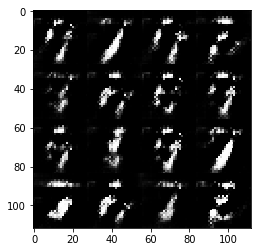

Epoch 0/2... Discriminator Loss: 0.5001... Generator Loss: 2.6407
Epoch 0/2... Discriminator Loss: 0.4951... Generator Loss: 3.4763
Epoch 0/2... Discriminator Loss: 0.4477... Generator Loss: 4.7864
Epoch 0/2... Discriminator Loss: 0.5405... Generator Loss: 2.8722
Epoch 0/2... Discriminator Loss: 0.9275... Generator Loss: 4.2673


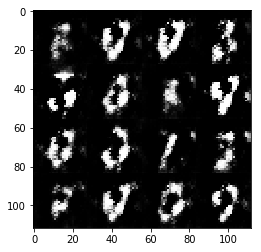

Epoch 0/2... Discriminator Loss: 1.3009... Generator Loss: 0.6143
Epoch 0/2... Discriminator Loss: 1.0678... Generator Loss: 3.4408
Epoch 0/2... Discriminator Loss: 0.6288... Generator Loss: 1.9723
Epoch 0/2... Discriminator Loss: 0.6173... Generator Loss: 2.0678
Epoch 0/2... Discriminator Loss: 0.5603... Generator Loss: 2.6701


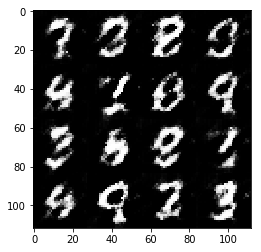

Epoch 0/2... Discriminator Loss: 0.9042... Generator Loss: 3.4631
Epoch 0/2... Discriminator Loss: 0.7116... Generator Loss: 1.5911
Epoch 0/2... Discriminator Loss: 0.5662... Generator Loss: 3.0597
Epoch 0/2... Discriminator Loss: 0.8278... Generator Loss: 1.6003
Epoch 0/2... Discriminator Loss: 0.8291... Generator Loss: 1.4773


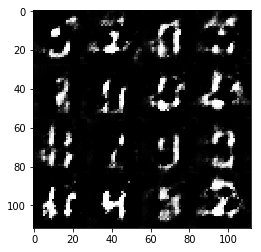

Epoch 0/2... Discriminator Loss: 0.6891... Generator Loss: 1.4850
Epoch 0/2... Discriminator Loss: 0.7421... Generator Loss: 1.3989
Epoch 0/2... Discriminator Loss: 0.5284... Generator Loss: 2.5754
Epoch 0/2... Discriminator Loss: 0.8970... Generator Loss: 1.0915
Epoch 0/2... Discriminator Loss: 0.7530... Generator Loss: 1.4743


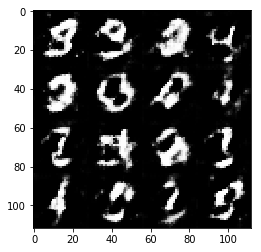

Epoch 0/2... Discriminator Loss: 0.9200... Generator Loss: 1.0776
Epoch 0/2... Discriminator Loss: 0.6584... Generator Loss: 1.6415
Epoch 0/2... Discriminator Loss: 0.6876... Generator Loss: 1.4498
Epoch 0/2... Discriminator Loss: 0.8476... Generator Loss: 2.4361
Epoch 0/2... Discriminator Loss: 1.0372... Generator Loss: 3.5287


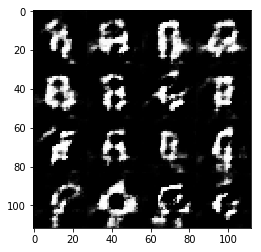

Epoch 0/2... Discriminator Loss: 0.8844... Generator Loss: 1.3312
Epoch 0/2... Discriminator Loss: 0.8208... Generator Loss: 1.3931
Epoch 0/2... Discriminator Loss: 0.6431... Generator Loss: 2.1445
Epoch 0/2... Discriminator Loss: 0.7030... Generator Loss: 2.1106
Epoch 0/2... Discriminator Loss: 0.6497... Generator Loss: 2.1029


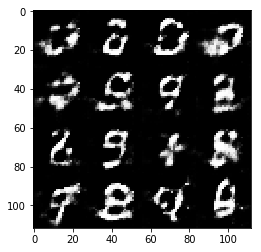

Epoch 0/2... Discriminator Loss: 0.8702... Generator Loss: 1.1724
Epoch 0/2... Discriminator Loss: 0.7455... Generator Loss: 1.4853
Epoch 0/2... Discriminator Loss: 0.9219... Generator Loss: 1.2061
Epoch 0/2... Discriminator Loss: 0.6796... Generator Loss: 1.8894
Epoch 0/2... Discriminator Loss: 0.9620... Generator Loss: 2.8356


Epoch 0/2... Discriminator Loss: 0.9951... Generator Loss: 0.9348
Epoch 0/2... Discriminator Loss: 0.8757... Generator Loss: 1.3877
Epoch 0/2... Discriminator Loss: 0.9921... Generator Loss: 0.9582
Epoch 0/2... Discriminator Loss: 1.4065... Generator Loss: 0.5922
Epoch 0/2... Discriminator Loss: 0.8453... Generator Loss: 1.5737


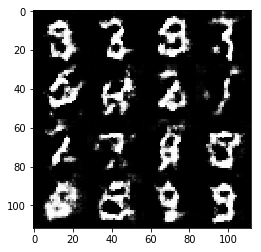

Epoch 0/2... Discriminator Loss: 0.9731... Generator Loss: 1.1907
Epoch 0/2... Discriminator Loss: 0.8841... Generator Loss: 2.1027
Epoch 0/2... Discriminator Loss: 0.8772... Generator Loss: 1.1206
Epoch 0/2... Discriminator Loss: 1.0882... Generator Loss: 2.4817
Epoch 0/2... Discriminator Loss: 0.7847... Generator Loss: 2.1524


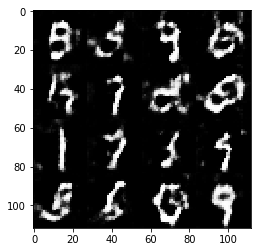

Epoch 0/2... Discriminator Loss: 0.7766... Generator Loss: 1.4884
Epoch 0/2... Discriminator Loss: 0.9726... Generator Loss: 1.1768
Epoch 0/2... Discriminator Loss: 0.9989... Generator Loss: 1.2018
Epoch 0/2... Discriminator Loss: 1.1001... Generator Loss: 0.8451
Epoch 0/2... Discriminator Loss: 0.7515... Generator Loss: 1.5117


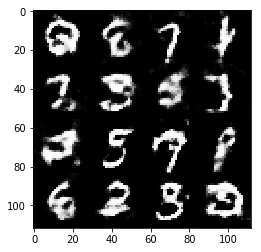

Epoch 0/2... Discriminator Loss: 1.0707... Generator Loss: 1.4478
Epoch 0/2... Discriminator Loss: 0.8908... Generator Loss: 1.1947
Epoch 0/2... Discriminator Loss: 0.9418... Generator Loss: 1.2718
Epoch 0/2... Discriminator Loss: 1.0666... Generator Loss: 0.8900
Epoch 0/2... Discriminator Loss: 0.9228... Generator Loss: 1.7361


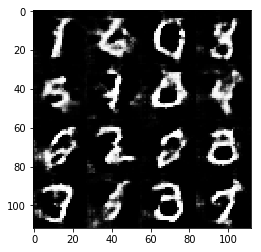

Epoch 0/2... Discriminator Loss: 0.9355... Generator Loss: 1.0889
Epoch 0/2... Discriminator Loss: 1.0848... Generator Loss: 1.9332
Epoch 0/2... Discriminator Loss: 1.0562... Generator Loss: 0.9216
Epoch 0/2... Discriminator Loss: 0.8749... Generator Loss: 1.2388
Epoch 0/2... Discriminator Loss: 0.9074... Generator Loss: 1.3043


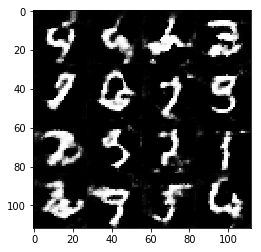

Epoch 0/2... Discriminator Loss: 1.0479... Generator Loss: 0.8775
Epoch 0/2... Discriminator Loss: 1.1317... Generator Loss: 1.0784
Epoch 0/2... Discriminator Loss: 0.8003... Generator Loss: 1.4045
Epoch 0/2... Discriminator Loss: 0.7553... Generator Loss: 2.0001
Epoch 0/2... Discriminator Loss: 0.7988... Generator Loss: 1.5107


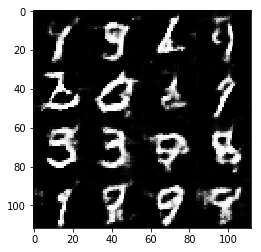

Epoch 0/2... Discriminator Loss: 1.1119... Generator Loss: 0.8644
Epoch 0/2... Discriminator Loss: 0.8854... Generator Loss: 1.0650
Epoch 0/2... Discriminator Loss: 1.0197... Generator Loss: 0.9051
Epoch 0/2... Discriminator Loss: 0.8786... Generator Loss: 1.4605
Epoch 0/2... Discriminator Loss: 0.8494... Generator Loss: 1.3228


Epoch 0/2... Discriminator Loss: 1.2657... Generator Loss: 2.3380
Epoch 0/2... Discriminator Loss: 0.9927... Generator Loss: 2.3305
Epoch 0/2... Discriminator Loss: 0.8544... Generator Loss: 1.1957
Epoch 0/2... Discriminator Loss: 1.3138... Generator Loss: 1.9998
Epoch 0/2... Discriminator Loss: 0.7941... Generator Loss: 1.8862


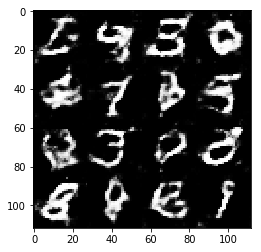

Epoch 0/2... Discriminator Loss: 1.0722... Generator Loss: 0.8661
Epoch 0/2... Discriminator Loss: 1.0687... Generator Loss: 1.8644
Epoch 0/2... Discriminator Loss: 0.8596... Generator Loss: 1.2369
Epoch 0/2... Discriminator Loss: 0.7976... Generator Loss: 1.5761
Epoch 0/2... Discriminator Loss: 0.9950... Generator Loss: 1.0269


Epoch 0/2... Discriminator Loss: 1.0768... Generator Loss: 0.9196
Epoch 0/2... Discriminator Loss: 1.0120... Generator Loss: 1.0122
Epoch 0/2... Discriminator Loss: 1.0984... Generator Loss: 0.7876
Epoch 0/2... Discriminator Loss: 0.8512... Generator Loss: 1.8741
Epoch 0/2... Discriminator Loss: 0.9827... Generator Loss: 1.6230


Epoch 0/2... Discriminator Loss: 0.7970... Generator Loss: 2.0008
Epoch 0/2... Discriminator Loss: 0.9790... Generator Loss: 1.0479
Epoch 0/2... Discriminator Loss: 0.9798... Generator Loss: 2.7251
Epoch 0/2... Discriminator Loss: 0.8722... Generator Loss: 1.9389
Epoch 0/2... Discriminator Loss: 1.1779... Generator Loss: 0.7027


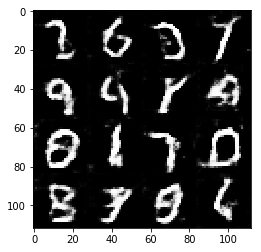

Epoch 0/2... Discriminator Loss: 0.8795... Generator Loss: 1.2682
Epoch 0/2... Discriminator Loss: 0.9061... Generator Loss: 1.1764
Epoch 0/2... Discriminator Loss: 1.1823... Generator Loss: 0.7313
Epoch 0/2... Discriminator Loss: 1.2952... Generator Loss: 0.5973
Epoch 0/2... Discriminator Loss: 0.8667... Generator Loss: 1.8315


Epoch 0/2... Discriminator Loss: 0.8490... Generator Loss: 1.8617
Epoch 0/2... Discriminator Loss: 0.7523... Generator Loss: 1.5072
Epoch 0/2... Discriminator Loss: 0.9536... Generator Loss: 1.2153
Epoch 0/2... Discriminator Loss: 0.9005... Generator Loss: 1.1586
Epoch 0/2... Discriminator Loss: 1.0381... Generator Loss: 0.9076


Epoch 0/2... Discriminator Loss: 0.8735... Generator Loss: 1.4274
Epoch 0/2... Discriminator Loss: 1.1746... Generator Loss: 0.6758
Epoch 0/2... Discriminator Loss: 1.0118... Generator Loss: 0.8245
Epoch 0/2... Discriminator Loss: 1.0813... Generator Loss: 1.7537
Epoch 0/2... Discriminator Loss: 0.7758... Generator Loss: 1.3625


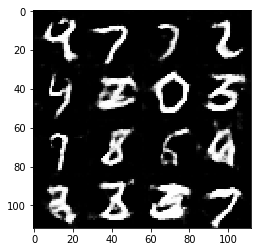

Epoch 0/2... Discriminator Loss: 0.7455... Generator Loss: 1.5011
Epoch 0/2... Discriminator Loss: 1.0227... Generator Loss: 1.8797
Epoch 0/2... Discriminator Loss: 0.9214... Generator Loss: 1.2599
Epoch 0/2... Discriminator Loss: 0.8483... Generator Loss: 1.2558
Epoch 0/2... Discriminator Loss: 0.9212... Generator Loss: 1.0131


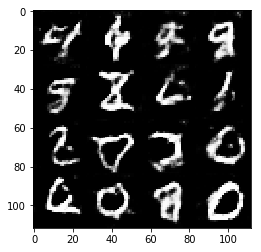

Epoch 0/2... Discriminator Loss: 0.8896... Generator Loss: 1.5261
Epoch 0/2... Discriminator Loss: 1.5918... Generator Loss: 0.4369
Epoch 0/2... Discriminator Loss: 1.0362... Generator Loss: 0.8595
Epoch 0/2... Discriminator Loss: 0.8122... Generator Loss: 1.2728
Epoch 0/2... Discriminator Loss: 1.0805... Generator Loss: 0.8054


Epoch 0/2... Discriminator Loss: 0.9069... Generator Loss: 1.0873
Epoch 0/2... Discriminator Loss: 0.8208... Generator Loss: 1.7726
Epoch 0/2... Discriminator Loss: 0.8714... Generator Loss: 1.1724
Epoch 0/2... Discriminator Loss: 0.8799... Generator Loss: 1.2062
Epoch 0/2... Discriminator Loss: 1.2138... Generator Loss: 0.6487


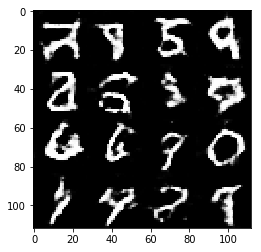

Epoch 0/2... Discriminator Loss: 0.8704... Generator Loss: 1.0820
Epoch 0/2... Discriminator Loss: 1.1281... Generator Loss: 0.7666
Epoch 0/2... Discriminator Loss: 0.7745... Generator Loss: 1.2570
Epoch 0/2... Discriminator Loss: 0.9460... Generator Loss: 1.7034
Epoch 0/2... Discriminator Loss: 0.7742... Generator Loss: 1.2747


Epoch 0/2... Discriminator Loss: 0.7563... Generator Loss: 1.8573
Epoch 0/2... Discriminator Loss: 0.8609... Generator Loss: 1.0608
Epoch 0/2... Discriminator Loss: 0.7504... Generator Loss: 1.3462
Epoch 0/2... Discriminator Loss: 0.8700... Generator Loss: 1.1978
Epoch 0/2... Discriminator Loss: 2.0141... Generator Loss: 0.3816


Epoch 0/2... Discriminator Loss: 0.7362... Generator Loss: 1.3910
Epoch 0/2... Discriminator Loss: 1.0431... Generator Loss: 0.8534
Epoch 0/2... Discriminator Loss: 0.7299... Generator Loss: 1.3614
Epoch 0/2... Discriminator Loss: 0.8015... Generator Loss: 1.1657
Epoch 0/2... Discriminator Loss: 0.9525... Generator Loss: 0.8671


Epoch 0/2... Discriminator Loss: 0.9191... Generator Loss: 1.0347
Epoch 0/2... Discriminator Loss: 1.5895... Generator Loss: 0.4608
Epoch 0/2... Discriminator Loss: 0.7167... Generator Loss: 1.2987
Epoch 0/2... Discriminator Loss: 1.1281... Generator Loss: 1.0181
Epoch 0/2... Discriminator Loss: 0.9710... Generator Loss: 1.0574


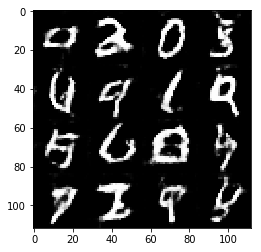

Epoch 0/2... Discriminator Loss: 0.7742... Generator Loss: 1.2351
Epoch 0/2... Discriminator Loss: 0.9593... Generator Loss: 0.9691
Epoch 0/2... Discriminator Loss: 0.8371... Generator Loss: 1.1619
Epoch 0/2... Discriminator Loss: 0.7176... Generator Loss: 1.7660
Epoch 0/2... Discriminator Loss: 0.9107... Generator Loss: 0.9191


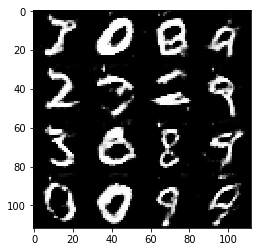

Epoch 0/2... Discriminator Loss: 0.8501... Generator Loss: 1.0984
Epoch 0/2... Discriminator Loss: 0.9360... Generator Loss: 0.9436
Epoch 0/2... Discriminator Loss: 1.5181... Generator Loss: 0.4561
Epoch 1/2... Discriminator Loss: 0.7172... Generator Loss: 2.4526
Epoch 1/2... Discriminator Loss: 0.7474... Generator Loss: 1.3200


Epoch 1/2... Discriminator Loss: 1.6569... Generator Loss: 0.3856
Epoch 1/2... Discriminator Loss: 1.0942... Generator Loss: 1.8830
Epoch 1/2... Discriminator Loss: 1.0561... Generator Loss: 0.8189
Epoch 1/2... Discriminator Loss: 1.1099... Generator Loss: 0.7149
Epoch 1/2... Discriminator Loss: 0.7510... Generator Loss: 1.2279


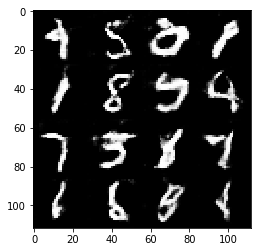

Epoch 1/2... Discriminator Loss: 0.9390... Generator Loss: 1.0016
Epoch 1/2... Discriminator Loss: 1.2380... Generator Loss: 0.6030
Epoch 1/2... Discriminator Loss: 0.8730... Generator Loss: 1.1935
Epoch 1/2... Discriminator Loss: 1.0944... Generator Loss: 0.7980
Epoch 1/2... Discriminator Loss: 1.0057... Generator Loss: 0.8413


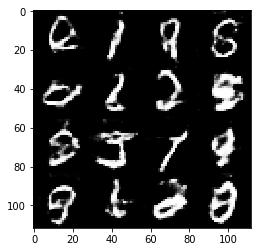

Epoch 1/2... Discriminator Loss: 0.9085... Generator Loss: 1.0147
Epoch 1/2... Discriminator Loss: 1.3678... Generator Loss: 0.5427
Epoch 1/2... Discriminator Loss: 0.9557... Generator Loss: 0.9510
Epoch 1/2... Discriminator Loss: 1.0044... Generator Loss: 1.1622
Epoch 1/2... Discriminator Loss: 1.0948... Generator Loss: 0.8488


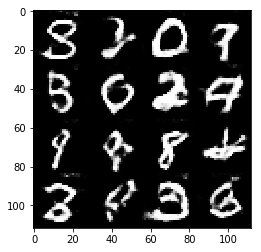

Epoch 1/2... Discriminator Loss: 0.9322... Generator Loss: 1.2265
Epoch 1/2... Discriminator Loss: 0.8226... Generator Loss: 1.7551
Epoch 1/2... Discriminator Loss: 0.8302... Generator Loss: 1.2095
Epoch 1/2... Discriminator Loss: 0.8322... Generator Loss: 1.6455
Epoch 1/2... Discriminator Loss: 0.8132... Generator Loss: 1.1640


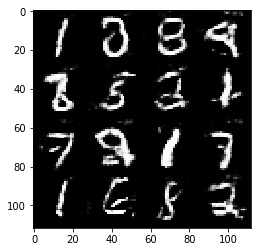

Epoch 1/2... Discriminator Loss: 1.0261... Generator Loss: 0.8981
Epoch 1/2... Discriminator Loss: 1.0131... Generator Loss: 0.8927
Epoch 1/2... Discriminator Loss: 1.1446... Generator Loss: 0.7111
Epoch 1/2... Discriminator Loss: 1.4517... Generator Loss: 0.4714
Epoch 1/2... Discriminator Loss: 0.7090... Generator Loss: 1.3795


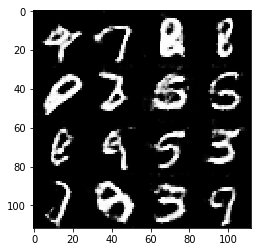

Epoch 1/2... Discriminator Loss: 0.7193... Generator Loss: 1.7348
Epoch 1/2... Discriminator Loss: 0.8730... Generator Loss: 1.1067
Epoch 1/2... Discriminator Loss: 0.8081... Generator Loss: 1.5759
Epoch 1/2... Discriminator Loss: 0.7196... Generator Loss: 1.3905
Epoch 1/2... Discriminator Loss: 1.9858... Generator Loss: 0.3925


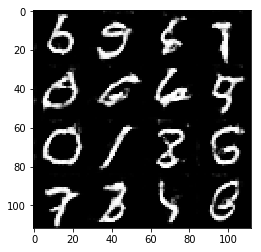

Epoch 1/2... Discriminator Loss: 1.1481... Generator Loss: 3.1409
Epoch 1/2... Discriminator Loss: 0.7376... Generator Loss: 1.6213
Epoch 1/2... Discriminator Loss: 1.0532... Generator Loss: 0.8360
Epoch 1/2... Discriminator Loss: 1.1763... Generator Loss: 0.7328
Epoch 1/2... Discriminator Loss: 0.8038... Generator Loss: 1.1345


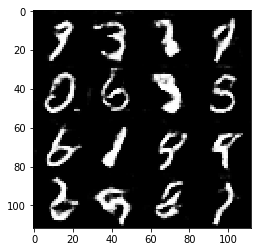

Epoch 1/2... Discriminator Loss: 1.0504... Generator Loss: 3.3293
Epoch 1/2... Discriminator Loss: 1.1872... Generator Loss: 0.6451
Epoch 1/2... Discriminator Loss: 0.7115... Generator Loss: 1.4971
Epoch 1/2... Discriminator Loss: 0.9262... Generator Loss: 1.3780
Epoch 1/2... Discriminator Loss: 0.8290... Generator Loss: 1.1444


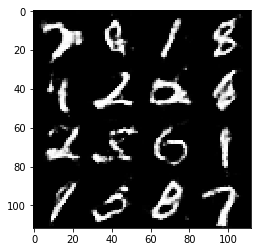

Epoch 1/2... Discriminator Loss: 0.7949... Generator Loss: 1.2326
Epoch 1/2... Discriminator Loss: 1.1292... Generator Loss: 0.7591
Epoch 1/2... Discriminator Loss: 0.9494... Generator Loss: 1.2722
Epoch 1/2... Discriminator Loss: 1.1477... Generator Loss: 0.7718
Epoch 1/2... Discriminator Loss: 1.0890... Generator Loss: 0.7569


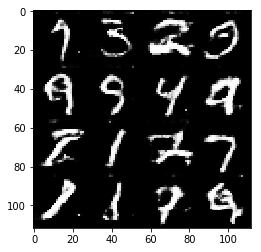

Epoch 1/2... Discriminator Loss: 1.0783... Generator Loss: 0.8156
Epoch 1/2... Discriminator Loss: 0.8459... Generator Loss: 1.3128
Epoch 1/2... Discriminator Loss: 2.1010... Generator Loss: 0.2564
Epoch 1/2... Discriminator Loss: 1.7160... Generator Loss: 0.3977
Epoch 1/2... Discriminator Loss: 0.8168... Generator Loss: 1.2917


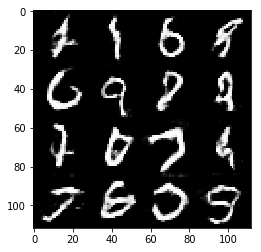

Epoch 1/2... Discriminator Loss: 0.8763... Generator Loss: 1.0120
Epoch 1/2... Discriminator Loss: 0.8655... Generator Loss: 1.0638
Epoch 1/2... Discriminator Loss: 0.7439... Generator Loss: 1.6201
Epoch 1/2... Discriminator Loss: 0.7060... Generator Loss: 1.6121
Epoch 1/2... Discriminator Loss: 0.8611... Generator Loss: 1.0800


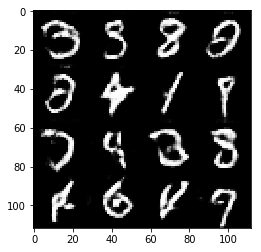

Epoch 1/2... Discriminator Loss: 0.7600... Generator Loss: 2.2721
Epoch 1/2... Discriminator Loss: 1.1159... Generator Loss: 0.7557
Epoch 1/2... Discriminator Loss: 0.9688... Generator Loss: 2.2901
Epoch 1/2... Discriminator Loss: 0.7154... Generator Loss: 1.8375
Epoch 1/2... Discriminator Loss: 1.2886... Generator Loss: 0.5969


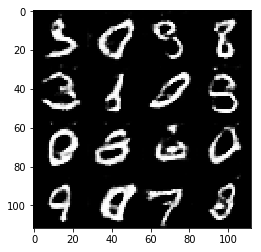

Epoch 1/2... Discriminator Loss: 0.7174... Generator Loss: 1.4164
Epoch 1/2... Discriminator Loss: 0.9916... Generator Loss: 0.9994
Epoch 1/2... Discriminator Loss: 0.7808... Generator Loss: 1.2284
Epoch 1/2... Discriminator Loss: 0.5492... Generator Loss: 2.1022
Epoch 1/2... Discriminator Loss: 2.4068... Generator Loss: 4.0674


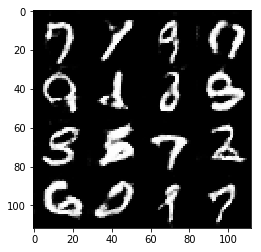

Epoch 1/2... Discriminator Loss: 0.6980... Generator Loss: 1.7687
Epoch 1/2... Discriminator Loss: 1.2767... Generator Loss: 0.6298
Epoch 1/2... Discriminator Loss: 0.7832... Generator Loss: 1.1994
Epoch 1/2... Discriminator Loss: 0.7279... Generator Loss: 1.4480
Epoch 1/2... Discriminator Loss: 0.9336... Generator Loss: 1.0088


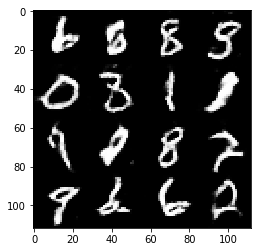

Epoch 1/2... Discriminator Loss: 0.9662... Generator Loss: 1.6160
Epoch 1/2... Discriminator Loss: 0.8406... Generator Loss: 1.3486
Epoch 1/2... Discriminator Loss: 0.7919... Generator Loss: 1.3282
Epoch 1/2... Discriminator Loss: 1.1269... Generator Loss: 2.2104
Epoch 1/2... Discriminator Loss: 0.7115... Generator Loss: 1.5270


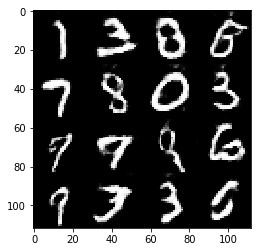

Epoch 1/2... Discriminator Loss: 1.1760... Generator Loss: 0.6895
Epoch 1/2... Discriminator Loss: 0.7745... Generator Loss: 2.6085
Epoch 1/2... Discriminator Loss: 1.6139... Generator Loss: 0.4001
Epoch 1/2... Discriminator Loss: 0.6856... Generator Loss: 1.4204
Epoch 1/2... Discriminator Loss: 0.8408... Generator Loss: 1.3165


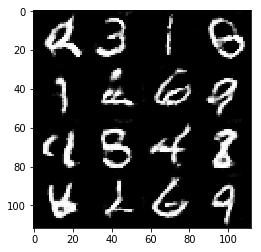

Epoch 1/2... Discriminator Loss: 0.9742... Generator Loss: 0.8707
Epoch 1/2... Discriminator Loss: 0.8869... Generator Loss: 1.0042
Epoch 1/2... Discriminator Loss: 1.1386... Generator Loss: 0.7401
Epoch 1/2... Discriminator Loss: 0.6307... Generator Loss: 1.9114
Epoch 1/2... Discriminator Loss: 0.6864... Generator Loss: 1.5605


Epoch 1/2... Discriminator Loss: 0.6109... Generator Loss: 1.9233
Epoch 1/2... Discriminator Loss: 1.0187... Generator Loss: 2.1907
Epoch 1/2... Discriminator Loss: 0.7975... Generator Loss: 1.4162
Epoch 1/2... Discriminator Loss: 0.8877... Generator Loss: 1.1352
Epoch 1/2... Discriminator Loss: 0.6388... Generator Loss: 1.9986


Epoch 1/2... Discriminator Loss: 0.6765... Generator Loss: 1.6204
Epoch 1/2... Discriminator Loss: 0.6686... Generator Loss: 1.6571
Epoch 1/2... Discriminator Loss: 0.9296... Generator Loss: 0.9753
Epoch 1/2... Discriminator Loss: 0.8391... Generator Loss: 2.2764
Epoch 1/2... Discriminator Loss: 0.7101... Generator Loss: 2.1266


Epoch 1/2... Discriminator Loss: 1.3953... Generator Loss: 0.5219
Epoch 1/2... Discriminator Loss: 0.7153... Generator Loss: 1.2898
Epoch 1/2... Discriminator Loss: 0.9086... Generator Loss: 0.9329
Epoch 1/2... Discriminator Loss: 1.7029... Generator Loss: 0.6133
Epoch 1/2... Discriminator Loss: 0.7599... Generator Loss: 1.5211


Epoch 1/2... Discriminator Loss: 0.7388... Generator Loss: 1.2894
Epoch 1/2... Discriminator Loss: 0.6849... Generator Loss: 1.5210
Epoch 1/2... Discriminator Loss: 0.7017... Generator Loss: 2.1231
Epoch 1/2... Discriminator Loss: 0.8925... Generator Loss: 1.0773
Epoch 1/2... Discriminator Loss: 1.0816... Generator Loss: 0.7989


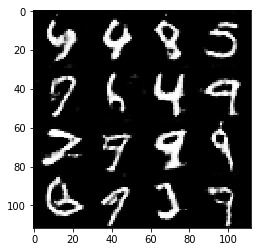

Epoch 1/2... Discriminator Loss: 0.7410... Generator Loss: 1.3603
Epoch 1/2... Discriminator Loss: 0.9164... Generator Loss: 0.9614
Epoch 1/2... Discriminator Loss: 0.7591... Generator Loss: 2.4499
Epoch 1/2... Discriminator Loss: 0.6063... Generator Loss: 1.6643
Epoch 1/2... Discriminator Loss: 0.8610... Generator Loss: 1.0682


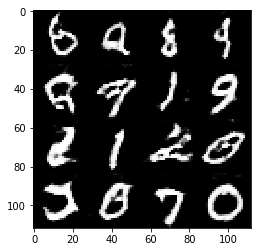

Epoch 1/2... Discriminator Loss: 0.6753... Generator Loss: 1.5251
Epoch 1/2... Discriminator Loss: 0.5489... Generator Loss: 1.9898
Epoch 1/2... Discriminator Loss: 0.5085... Generator Loss: 2.2555
Epoch 1/2... Discriminator Loss: 0.7783... Generator Loss: 2.8225
Epoch 1/2... Discriminator Loss: 1.4127... Generator Loss: 0.6622


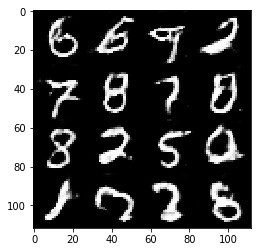

Epoch 1/2... Discriminator Loss: 1.0474... Generator Loss: 0.8470
Epoch 1/2... Discriminator Loss: 1.3442... Generator Loss: 0.6087
Epoch 1/2... Discriminator Loss: 0.6043... Generator Loss: 1.8654
Epoch 1/2... Discriminator Loss: 0.7323... Generator Loss: 1.3675
Epoch 1/2... Discriminator Loss: 0.7091... Generator Loss: 1.3334


Epoch 1/2... Discriminator Loss: 0.7617... Generator Loss: 1.3338
Epoch 1/2... Discriminator Loss: 0.6682... Generator Loss: 1.6011
Epoch 1/2... Discriminator Loss: 1.3468... Generator Loss: 3.1954
Epoch 1/2... Discriminator Loss: 1.3172... Generator Loss: 3.4379
Epoch 1/2... Discriminator Loss: 1.2958... Generator Loss: 0.5715


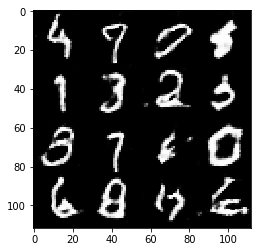

Epoch 1/2... Discriminator Loss: 0.8024... Generator Loss: 2.0492
Epoch 1/2... Discriminator Loss: 0.7469... Generator Loss: 1.4780
Epoch 1/2... Discriminator Loss: 0.7283... Generator Loss: 1.3375
Epoch 1/2... Discriminator Loss: 0.5621... Generator Loss: 1.9918
Epoch 1/2... Discriminator Loss: 0.6519... Generator Loss: 1.7631


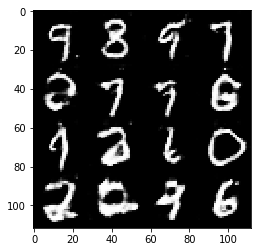

Epoch 1/2... Discriminator Loss: 0.7122... Generator Loss: 1.3328
Epoch 1/2... Discriminator Loss: 0.9920... Generator Loss: 0.8698
Epoch 1/2... Discriminator Loss: 0.7120... Generator Loss: 1.4903
Epoch 1/2... Discriminator Loss: 0.5211... Generator Loss: 2.1909
Epoch 1/2... Discriminator Loss: 1.0834... Generator Loss: 0.8910


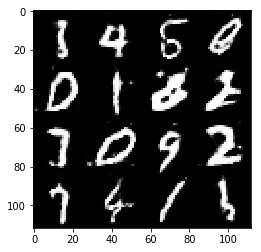

Epoch 1/2... Discriminator Loss: 0.6699... Generator Loss: 2.0241
Epoch 1/2... Discriminator Loss: 0.7286... Generator Loss: 1.3925
Epoch 1/2... Discriminator Loss: 0.6183... Generator Loss: 1.7121
Epoch 1/2... Discriminator Loss: 0.6972... Generator Loss: 1.6254
Epoch 1/2... Discriminator Loss: 1.6589... Generator Loss: 0.6288


Epoch 1/2... Discriminator Loss: 0.8060... Generator Loss: 1.2298
Epoch 1/2... Discriminator Loss: 0.6928... Generator Loss: 1.3949
Epoch 1/2... Discriminator Loss: 0.6126... Generator Loss: 1.7040
Epoch 1/2... Discriminator Loss: 0.6326... Generator Loss: 1.6786
Epoch 1/2... Discriminator Loss: 0.7307... Generator Loss: 1.3437


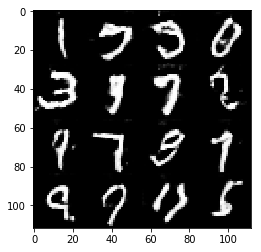

Epoch 1/2... Discriminator Loss: 0.7716... Generator Loss: 1.4473
Epoch 1/2... Discriminator Loss: 1.2382... Generator Loss: 3.6859
Epoch 1/2... Discriminator Loss: 0.9941... Generator Loss: 0.8912
Epoch 1/2... Discriminator Loss: 1.0158... Generator Loss: 0.8042
Epoch 1/2... Discriminator Loss: 0.6947... Generator Loss: 2.0903


Epoch 1/2... Discriminator Loss: 0.6651... Generator Loss: 1.5685
Epoch 1/2... Discriminator Loss: 0.6135... Generator Loss: 2.1513
Epoch 1/2... Discriminator Loss: 0.8541... Generator Loss: 1.0815
Epoch 1/2... Discriminator Loss: 0.7004... Generator Loss: 1.4052
Epoch 1/2... Discriminator Loss: 1.6607... Generator Loss: 0.4249


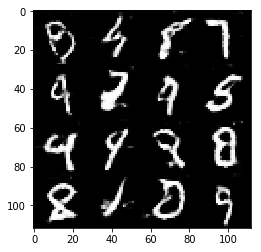

Epoch 1/2... Discriminator Loss: 1.0731... Generator Loss: 0.9660
Epoch 1/2... Discriminator Loss: 0.6731... Generator Loss: 1.8004
Epoch 1/2... Discriminator Loss: 1.1989... Generator Loss: 0.7408
Epoch 1/2... Discriminator Loss: 1.3239... Generator Loss: 0.6490
Epoch 1/2... Discriminator Loss: 0.8532... Generator Loss: 1.0302


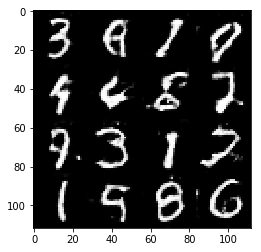

Epoch 1/2... Discriminator Loss: 1.4262... Generator Loss: 0.5874
Epoch 1/2... Discriminator Loss: 0.7692... Generator Loss: 1.2271
Epoch 1/2... Discriminator Loss: 1.0045... Generator Loss: 0.9389
Epoch 1/2... Discriminator Loss: 0.9570... Generator Loss: 1.0003
Epoch 1/2... Discriminator Loss: 0.8390... Generator Loss: 1.1956


Epoch 1/2... Discriminator Loss: 0.5700... Generator Loss: 1.7693
Epoch 1/2... Discriminator Loss: 0.7119... Generator Loss: 1.4373
Epoch 1/2... Discriminator Loss: 0.9262... Generator Loss: 1.0204
Epoch 1/2... Discriminator Loss: 0.6846... Generator Loss: 1.4805
Epoch 1/2... Discriminator Loss: 1.0709... Generator Loss: 0.7985


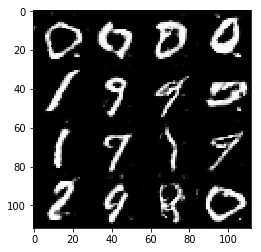

Epoch 1/2... Discriminator Loss: 0.6854... Generator Loss: 1.3870
Epoch 1/2... Discriminator Loss: 0.8582... Generator Loss: 3.8128
Epoch 1/2... Discriminator Loss: 0.5686... Generator Loss: 1.8587
Epoch 1/2... Discriminator Loss: 0.8642... Generator Loss: 0.9926
Epoch 1/2... Discriminator Loss: 1.5823... Generator Loss: 0.6207


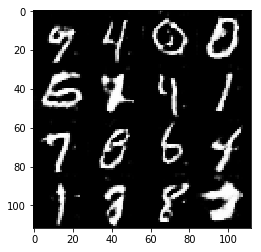

Epoch 1/2... Discriminator Loss: 0.6448... Generator Loss: 1.8360
Epoch 1/2... Discriminator Loss: 1.1060... Generator Loss: 1.0406
Epoch 1/2... Discriminator Loss: 0.6559... Generator Loss: 1.4445
Epoch 1/2... Discriminator Loss: 0.5976... Generator Loss: 1.6931
Epoch 1/2... Discriminator Loss: 0.6179... Generator Loss: 1.7013


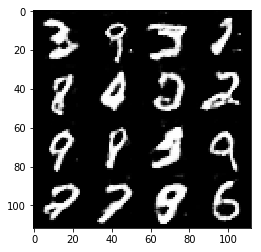

Epoch 1/2... Discriminator Loss: 0.5185... Generator Loss: 2.2262
Epoch 1/2... Discriminator Loss: 0.5804... Generator Loss: 2.7913
Epoch 1/2... Discriminator Loss: 1.2290... Generator Loss: 0.6767
Epoch 1/2... Discriminator Loss: 0.9265... Generator Loss: 0.9868
Epoch 1/2... Discriminator Loss: 0.5498... Generator Loss: 1.9418


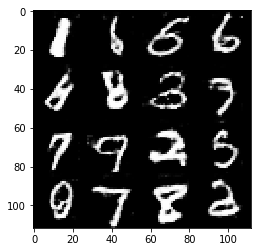

Epoch 1/2... Discriminator Loss: 0.6224... Generator Loss: 1.6825


In [17]:
batch_size = 32
z_dim = 128
learning_rate = 0.0003
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 0.6574... Generator Loss: 5.7006
Epoch 0/1... Discriminator Loss: 0.4223... Generator Loss: 7.6270
Epoch 0/1... Discriminator Loss: 0.8255... Generator Loss: 10.7610
Epoch 0/1... Discriminator Loss: 0.3918... Generator Loss: 3.8180


Epoch 0/1... Discriminator Loss: 0.4400... Generator Loss: 7.6354
Epoch 0/1... Discriminator Loss: 0.8311... Generator Loss: 1.0724
Epoch 0/1... Discriminator Loss: 0.7917... Generator Loss: 1.3067
Epoch 0/1... Discriminator Loss: 0.8381... Generator Loss: 1.2251
Epoch 0/1... Discriminator Loss: 0.8131... Generator Loss: 1.1409


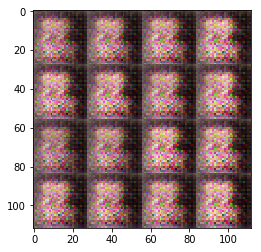

Epoch 0/1... Discriminator Loss: 0.6672... Generator Loss: 7.5283
Epoch 0/1... Discriminator Loss: 0.5705... Generator Loss: 2.2549
Epoch 0/1... Discriminator Loss: 0.4900... Generator Loss: 2.6624
Epoch 0/1... Discriminator Loss: 0.6761... Generator Loss: 1.8104
Epoch 0/1... Discriminator Loss: 0.7345... Generator Loss: 1.5032


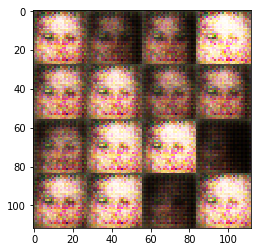

Epoch 0/1... Discriminator Loss: 1.0923... Generator Loss: 0.8369
Epoch 0/1... Discriminator Loss: 0.7374... Generator Loss: 1.3550
Epoch 0/1... Discriminator Loss: 0.6177... Generator Loss: 2.7013
Epoch 0/1... Discriminator Loss: 0.6131... Generator Loss: 2.4289
Epoch 0/1... Discriminator Loss: 0.6694... Generator Loss: 2.3978


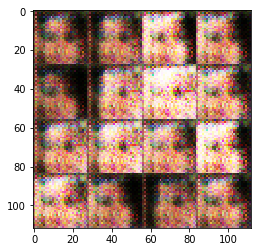

Epoch 0/1... Discriminator Loss: 0.6311... Generator Loss: 1.7489
Epoch 0/1... Discriminator Loss: 1.1007... Generator Loss: 0.7654
Epoch 0/1... Discriminator Loss: 0.9041... Generator Loss: 1.0291
Epoch 0/1... Discriminator Loss: 0.9609... Generator Loss: 0.8983
Epoch 0/1... Discriminator Loss: 1.0745... Generator Loss: 3.9379


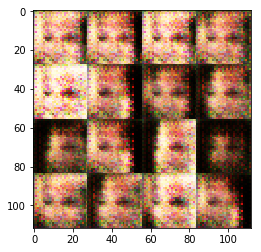

Epoch 0/1... Discriminator Loss: 0.8366... Generator Loss: 1.2442
Epoch 0/1... Discriminator Loss: 1.6363... Generator Loss: 0.4138
Epoch 0/1... Discriminator Loss: 1.0525... Generator Loss: 2.1994
Epoch 0/1... Discriminator Loss: 0.8292... Generator Loss: 1.5181
Epoch 0/1... Discriminator Loss: 1.4212... Generator Loss: 1.7522


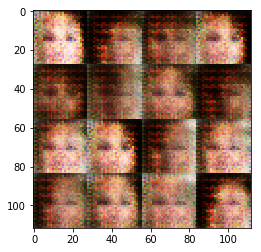

Epoch 0/1... Discriminator Loss: 1.0827... Generator Loss: 1.3512
Epoch 0/1... Discriminator Loss: 0.9943... Generator Loss: 0.8722
Epoch 0/1... Discriminator Loss: 1.2278... Generator Loss: 2.7302
Epoch 0/1... Discriminator Loss: 0.9231... Generator Loss: 1.5855
Epoch 0/1... Discriminator Loss: 0.7464... Generator Loss: 2.3239


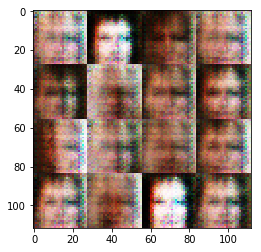

Epoch 0/1... Discriminator Loss: 1.1161... Generator Loss: 0.9215
Epoch 0/1... Discriminator Loss: 1.1971... Generator Loss: 1.0268
Epoch 0/1... Discriminator Loss: 1.0478... Generator Loss: 1.2955
Epoch 0/1... Discriminator Loss: 1.2284... Generator Loss: 1.6685
Epoch 0/1... Discriminator Loss: 1.1000... Generator Loss: 1.0704


Epoch 0/1... Discriminator Loss: 1.2316... Generator Loss: 0.7088
Epoch 0/1... Discriminator Loss: 0.8658... Generator Loss: 1.3066
Epoch 0/1... Discriminator Loss: 1.2095... Generator Loss: 0.8816
Epoch 0/1... Discriminator Loss: 0.9444... Generator Loss: 1.3770
Epoch 0/1... Discriminator Loss: 0.8835... Generator Loss: 1.0556


Epoch 0/1... Discriminator Loss: 0.8421... Generator Loss: 2.1919
Epoch 0/1... Discriminator Loss: 1.5837... Generator Loss: 0.7111
Epoch 0/1... Discriminator Loss: 1.3255... Generator Loss: 1.4288
Epoch 0/1... Discriminator Loss: 1.0236... Generator Loss: 0.9892
Epoch 0/1... Discriminator Loss: 1.6485... Generator Loss: 0.4121


Epoch 0/1... Discriminator Loss: 0.7345... Generator Loss: 1.5533
Epoch 0/1... Discriminator Loss: 1.4798... Generator Loss: 0.5539
Epoch 0/1... Discriminator Loss: 1.1075... Generator Loss: 0.9402
Epoch 0/1... Discriminator Loss: 1.3027... Generator Loss: 0.6694
Epoch 0/1... Discriminator Loss: 1.0733... Generator Loss: 1.0842


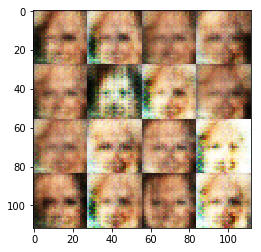

Epoch 0/1... Discriminator Loss: 1.1429... Generator Loss: 1.0022
Epoch 0/1... Discriminator Loss: 0.9733... Generator Loss: 1.9154
Epoch 0/1... Discriminator Loss: 1.4110... Generator Loss: 2.2123
Epoch 0/1... Discriminator Loss: 0.9945... Generator Loss: 1.2589
Epoch 0/1... Discriminator Loss: 1.1102... Generator Loss: 1.3110


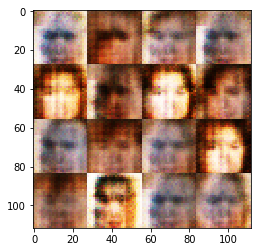

Epoch 0/1... Discriminator Loss: 0.7885... Generator Loss: 1.3796
Epoch 0/1... Discriminator Loss: 1.3487... Generator Loss: 0.7798
Epoch 0/1... Discriminator Loss: 1.2782... Generator Loss: 0.8295
Epoch 0/1... Discriminator Loss: 1.1059... Generator Loss: 1.0738
Epoch 0/1... Discriminator Loss: 1.0992... Generator Loss: 1.3124


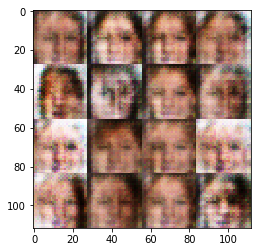

Epoch 0/1... Discriminator Loss: 0.9844... Generator Loss: 2.1402
Epoch 0/1... Discriminator Loss: 0.7532... Generator Loss: 1.9606
Epoch 0/1... Discriminator Loss: 0.9978... Generator Loss: 0.8856
Epoch 0/1... Discriminator Loss: 1.3223... Generator Loss: 0.9220
Epoch 0/1... Discriminator Loss: 0.9322... Generator Loss: 1.2089


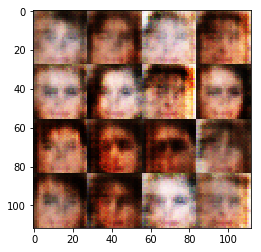

Epoch 0/1... Discriminator Loss: 0.8919... Generator Loss: 1.5773
Epoch 0/1... Discriminator Loss: 1.0527... Generator Loss: 1.8297
Epoch 0/1... Discriminator Loss: 1.0139... Generator Loss: 1.7671
Epoch 0/1... Discriminator Loss: 0.9545... Generator Loss: 1.8443
Epoch 0/1... Discriminator Loss: 0.7500... Generator Loss: 1.6183


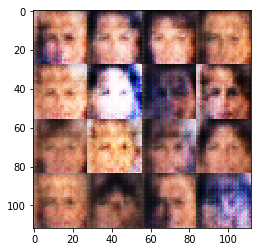

Epoch 0/1... Discriminator Loss: 0.8063... Generator Loss: 1.5844
Epoch 0/1... Discriminator Loss: 0.8871... Generator Loss: 1.3838
Epoch 0/1... Discriminator Loss: 0.8319... Generator Loss: 1.8124
Epoch 0/1... Discriminator Loss: 1.0979... Generator Loss: 0.9934
Epoch 0/1... Discriminator Loss: 1.0081... Generator Loss: 1.6389


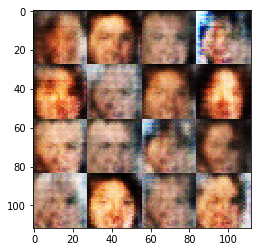

Epoch 0/1... Discriminator Loss: 1.2808... Generator Loss: 0.6561
Epoch 0/1... Discriminator Loss: 1.3186... Generator Loss: 1.0040
Epoch 0/1... Discriminator Loss: 1.2149... Generator Loss: 1.0479
Epoch 0/1... Discriminator Loss: 1.0967... Generator Loss: 0.8782
Epoch 0/1... Discriminator Loss: 0.7486... Generator Loss: 1.9361


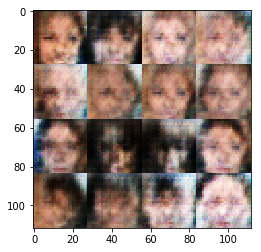

Epoch 0/1... Discriminator Loss: 1.0602... Generator Loss: 0.9781
Epoch 0/1... Discriminator Loss: 0.7650... Generator Loss: 1.5234
Epoch 0/1... Discriminator Loss: 0.7763... Generator Loss: 1.4055
Epoch 0/1... Discriminator Loss: 0.8883... Generator Loss: 1.4352
Epoch 0/1... Discriminator Loss: 1.1950... Generator Loss: 1.4591


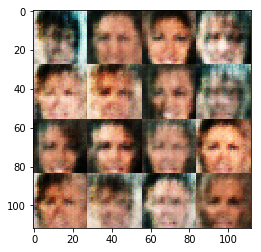

Epoch 0/1... Discriminator Loss: 1.1442... Generator Loss: 0.9087
Epoch 0/1... Discriminator Loss: 1.2092... Generator Loss: 0.7163
Epoch 0/1... Discriminator Loss: 1.2256... Generator Loss: 0.9572
Epoch 0/1... Discriminator Loss: 1.0480... Generator Loss: 1.2174
Epoch 0/1... Discriminator Loss: 1.1220... Generator Loss: 0.9554


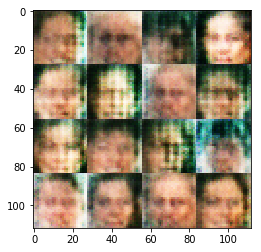

Epoch 0/1... Discriminator Loss: 1.0273... Generator Loss: 1.1054
Epoch 0/1... Discriminator Loss: 1.0451... Generator Loss: 0.9157
Epoch 0/1... Discriminator Loss: 1.4466... Generator Loss: 0.5687
Epoch 0/1... Discriminator Loss: 1.0370... Generator Loss: 1.8259
Epoch 0/1... Discriminator Loss: 1.1533... Generator Loss: 1.8645


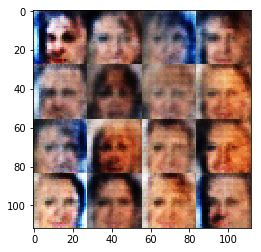

Epoch 0/1... Discriminator Loss: 1.3578... Generator Loss: 0.6543
Epoch 0/1... Discriminator Loss: 1.4907... Generator Loss: 0.5280
Epoch 0/1... Discriminator Loss: 1.0694... Generator Loss: 1.2243
Epoch 0/1... Discriminator Loss: 1.0989... Generator Loss: 1.4303
Epoch 0/1... Discriminator Loss: 0.9028... Generator Loss: 1.2327


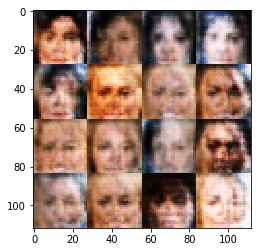

Epoch 0/1... Discriminator Loss: 1.0724... Generator Loss: 1.0233
Epoch 0/1... Discriminator Loss: 1.1157... Generator Loss: 0.8591
Epoch 0/1... Discriminator Loss: 1.0488... Generator Loss: 0.9245
Epoch 0/1... Discriminator Loss: 0.9923... Generator Loss: 1.1973
Epoch 0/1... Discriminator Loss: 1.2181... Generator Loss: 1.8358


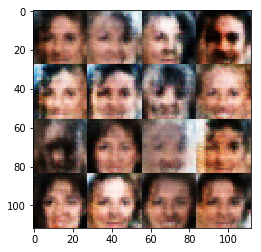

Epoch 0/1... Discriminator Loss: 0.9439... Generator Loss: 1.3153
Epoch 0/1... Discriminator Loss: 1.2437... Generator Loss: 0.6907
Epoch 0/1... Discriminator Loss: 1.2655... Generator Loss: 0.9245
Epoch 0/1... Discriminator Loss: 1.1958... Generator Loss: 0.8737
Epoch 0/1... Discriminator Loss: 1.2900... Generator Loss: 1.4453


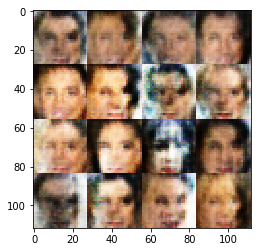

Epoch 0/1... Discriminator Loss: 1.1807... Generator Loss: 1.1552
Epoch 0/1... Discriminator Loss: 1.0495... Generator Loss: 1.3737
Epoch 0/1... Discriminator Loss: 1.1313... Generator Loss: 1.2195
Epoch 0/1... Discriminator Loss: 1.1365... Generator Loss: 1.0444
Epoch 0/1... Discriminator Loss: 1.3833... Generator Loss: 0.6641


Epoch 0/1... Discriminator Loss: 1.0133... Generator Loss: 1.1240
Epoch 0/1... Discriminator Loss: 1.1621... Generator Loss: 0.9014
Epoch 0/1... Discriminator Loss: 1.1150... Generator Loss: 0.9449
Epoch 0/1... Discriminator Loss: 1.4363... Generator Loss: 0.5527
Epoch 0/1... Discriminator Loss: 1.1240... Generator Loss: 0.9497


Epoch 0/1... Discriminator Loss: 1.0410... Generator Loss: 1.0374
Epoch 0/1... Discriminator Loss: 1.3775... Generator Loss: 0.6608
Epoch 0/1... Discriminator Loss: 1.2453... Generator Loss: 0.7317
Epoch 0/1... Discriminator Loss: 1.1753... Generator Loss: 1.2159
Epoch 0/1... Discriminator Loss: 1.1376... Generator Loss: 1.0510


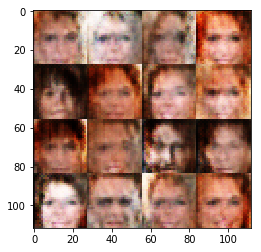

Epoch 0/1... Discriminator Loss: 1.1815... Generator Loss: 1.2918
Epoch 0/1... Discriminator Loss: 1.1003... Generator Loss: 1.2070
Epoch 0/1... Discriminator Loss: 0.9553... Generator Loss: 1.0378
Epoch 0/1... Discriminator Loss: 1.3450... Generator Loss: 0.6295
Epoch 0/1... Discriminator Loss: 1.1312... Generator Loss: 0.8098


Epoch 0/1... Discriminator Loss: 1.0978... Generator Loss: 0.8596
Epoch 0/1... Discriminator Loss: 1.2493... Generator Loss: 0.9313
Epoch 0/1... Discriminator Loss: 1.2081... Generator Loss: 0.7894
Epoch 0/1... Discriminator Loss: 1.1354... Generator Loss: 0.9717
Epoch 0/1... Discriminator Loss: 1.2997... Generator Loss: 0.7345


Epoch 0/1... Discriminator Loss: 1.0160... Generator Loss: 0.9483
Epoch 0/1... Discriminator Loss: 1.3112... Generator Loss: 0.6901
Epoch 0/1... Discriminator Loss: 1.0156... Generator Loss: 1.5061
Epoch 0/1... Discriminator Loss: 1.0921... Generator Loss: 0.9907
Epoch 0/1... Discriminator Loss: 1.0474... Generator Loss: 1.3648


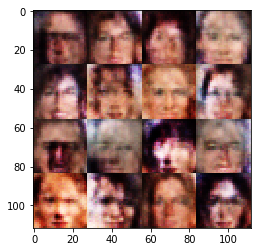

Epoch 0/1... Discriminator Loss: 1.0275... Generator Loss: 1.1160
Epoch 0/1... Discriminator Loss: 1.1194... Generator Loss: 1.1185
Epoch 0/1... Discriminator Loss: 1.1333... Generator Loss: 0.9789
Epoch 0/1... Discriminator Loss: 0.9889... Generator Loss: 1.1235
Epoch 0/1... Discriminator Loss: 1.0139... Generator Loss: 0.9382


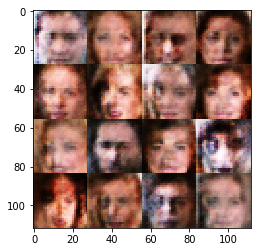

Epoch 0/1... Discriminator Loss: 1.0121... Generator Loss: 1.0273
Epoch 0/1... Discriminator Loss: 1.1545... Generator Loss: 1.0145
Epoch 0/1... Discriminator Loss: 1.2427... Generator Loss: 0.8165
Epoch 0/1... Discriminator Loss: 1.1665... Generator Loss: 0.9203
Epoch 0/1... Discriminator Loss: 1.0566... Generator Loss: 1.1799


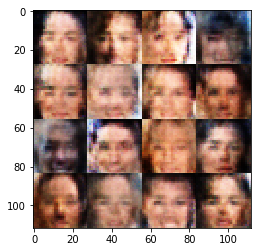

Epoch 0/1... Discriminator Loss: 1.2552... Generator Loss: 1.6844
Epoch 0/1... Discriminator Loss: 1.1379... Generator Loss: 0.9315
Epoch 0/1... Discriminator Loss: 0.8867... Generator Loss: 1.2137
Epoch 0/1... Discriminator Loss: 0.9182... Generator Loss: 1.0433
Epoch 0/1... Discriminator Loss: 1.1541... Generator Loss: 1.4688


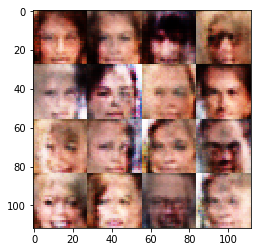

Epoch 0/1... Discriminator Loss: 1.0419... Generator Loss: 1.0510
Epoch 0/1... Discriminator Loss: 1.3618... Generator Loss: 0.5556
Epoch 0/1... Discriminator Loss: 1.3583... Generator Loss: 0.7541
Epoch 0/1... Discriminator Loss: 1.3419... Generator Loss: 1.7807
Epoch 0/1... Discriminator Loss: 1.1290... Generator Loss: 0.7298


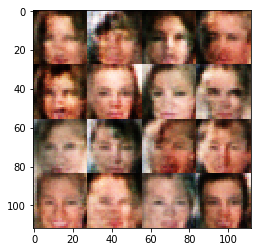

Epoch 0/1... Discriminator Loss: 1.1814... Generator Loss: 0.9403
Epoch 0/1... Discriminator Loss: 1.1414... Generator Loss: 0.6854
Epoch 0/1... Discriminator Loss: 1.2358... Generator Loss: 0.7488
Epoch 0/1... Discriminator Loss: 1.0347... Generator Loss: 1.1337
Epoch 0/1... Discriminator Loss: 0.9837... Generator Loss: 1.1828


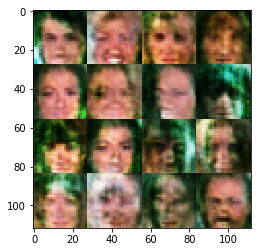

Epoch 0/1... Discriminator Loss: 1.0380... Generator Loss: 1.0948
Epoch 0/1... Discriminator Loss: 1.2530... Generator Loss: 0.6927
Epoch 0/1... Discriminator Loss: 1.0030... Generator Loss: 1.8513
Epoch 0/1... Discriminator Loss: 1.1641... Generator Loss: 1.2211
Epoch 0/1... Discriminator Loss: 0.9732... Generator Loss: 1.3395


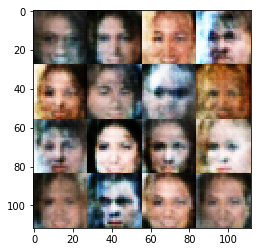

Epoch 0/1... Discriminator Loss: 1.0764... Generator Loss: 0.7935
Epoch 0/1... Discriminator Loss: 1.1830... Generator Loss: 1.2436
Epoch 0/1... Discriminator Loss: 1.1117... Generator Loss: 0.9794
Epoch 0/1... Discriminator Loss: 1.2039... Generator Loss: 0.7614
Epoch 0/1... Discriminator Loss: 1.0413... Generator Loss: 1.4126


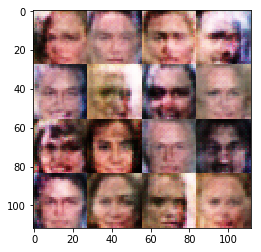

Epoch 0/1... Discriminator Loss: 0.8261... Generator Loss: 1.4932
Epoch 0/1... Discriminator Loss: 1.1877... Generator Loss: 0.7096
Epoch 0/1... Discriminator Loss: 0.9746... Generator Loss: 1.0816
Epoch 0/1... Discriminator Loss: 0.9561... Generator Loss: 1.2883
Epoch 0/1... Discriminator Loss: 1.0124... Generator Loss: 0.8940


Epoch 0/1... Discriminator Loss: 1.0425... Generator Loss: 2.5075
Epoch 0/1... Discriminator Loss: 0.9643... Generator Loss: 1.0842
Epoch 0/1... Discriminator Loss: 1.1793... Generator Loss: 0.8313
Epoch 0/1... Discriminator Loss: 1.2038... Generator Loss: 0.6293
Epoch 0/1... Discriminator Loss: 0.9383... Generator Loss: 1.3868


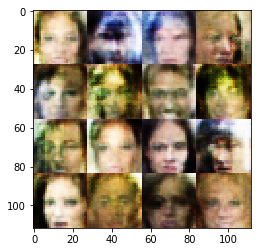

Epoch 0/1... Discriminator Loss: 1.0439... Generator Loss: 1.1880
Epoch 0/1... Discriminator Loss: 1.3123... Generator Loss: 0.6020
Epoch 0/1... Discriminator Loss: 1.4599... Generator Loss: 0.4372
Epoch 0/1... Discriminator Loss: 1.0508... Generator Loss: 1.2614
Epoch 0/1... Discriminator Loss: 1.1700... Generator Loss: 0.7272


Epoch 0/1... Discriminator Loss: 1.5907... Generator Loss: 0.3997
Epoch 0/1... Discriminator Loss: 1.2896... Generator Loss: 0.8356
Epoch 0/1... Discriminator Loss: 1.3792... Generator Loss: 0.6627
Epoch 0/1... Discriminator Loss: 0.9565... Generator Loss: 1.2810
Epoch 0/1... Discriminator Loss: 1.0678... Generator Loss: 0.9486


Epoch 0/1... Discriminator Loss: 1.3797... Generator Loss: 0.6398
Epoch 0/1... Discriminator Loss: 1.1263... Generator Loss: 0.7610
Epoch 0/1... Discriminator Loss: 0.9151... Generator Loss: 1.4154
Epoch 0/1... Discriminator Loss: 1.0384... Generator Loss: 1.6276
Epoch 0/1... Discriminator Loss: 0.9383... Generator Loss: 1.5314


Epoch 0/1... Discriminator Loss: 1.0385... Generator Loss: 0.8887
Epoch 0/1... Discriminator Loss: 1.1460... Generator Loss: 0.7969
Epoch 0/1... Discriminator Loss: 1.0743... Generator Loss: 0.9186
Epoch 0/1... Discriminator Loss: 1.3023... Generator Loss: 0.6219
Epoch 0/1... Discriminator Loss: 1.1724... Generator Loss: 1.9290


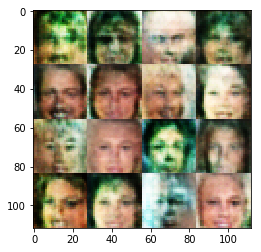

Epoch 0/1... Discriminator Loss: 1.1699... Generator Loss: 0.7451
Epoch 0/1... Discriminator Loss: 1.0663... Generator Loss: 0.8319
Epoch 0/1... Discriminator Loss: 1.1776... Generator Loss: 0.7509
Epoch 0/1... Discriminator Loss: 1.0517... Generator Loss: 1.0408
Epoch 0/1... Discriminator Loss: 0.9273... Generator Loss: 1.1910


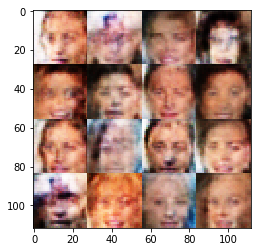

Epoch 0/1... Discriminator Loss: 1.0948... Generator Loss: 0.9830
Epoch 0/1... Discriminator Loss: 0.9479... Generator Loss: 1.2137
Epoch 0/1... Discriminator Loss: 0.7438... Generator Loss: 2.0142
Epoch 0/1... Discriminator Loss: 0.9687... Generator Loss: 1.4177
Epoch 0/1... Discriminator Loss: 1.1587... Generator Loss: 1.4356


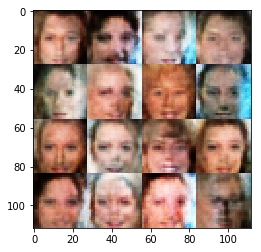

Epoch 0/1... Discriminator Loss: 0.9693... Generator Loss: 1.2578
Epoch 0/1... Discriminator Loss: 1.0409... Generator Loss: 0.9197
Epoch 0/1... Discriminator Loss: 1.3468... Generator Loss: 0.5480
Epoch 0/1... Discriminator Loss: 1.1855... Generator Loss: 0.7429
Epoch 0/1... Discriminator Loss: 1.2637... Generator Loss: 0.6141


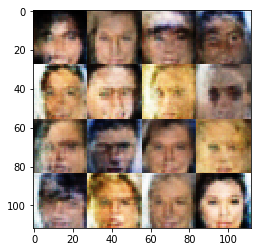

Epoch 0/1... Discriminator Loss: 1.2834... Generator Loss: 0.6352
Epoch 0/1... Discriminator Loss: 1.3384... Generator Loss: 0.5833
Epoch 0/1... Discriminator Loss: 1.3570... Generator Loss: 0.5230
Epoch 0/1... Discriminator Loss: 1.1962... Generator Loss: 0.7336
Epoch 0/1... Discriminator Loss: 0.9198... Generator Loss: 0.9852


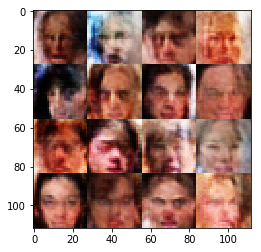

Epoch 0/1... Discriminator Loss: 1.2387... Generator Loss: 1.0652
Epoch 0/1... Discriminator Loss: 1.2128... Generator Loss: 2.0633
Epoch 0/1... Discriminator Loss: 0.9140... Generator Loss: 0.9937
Epoch 0/1... Discriminator Loss: 0.8388... Generator Loss: 1.2227
Epoch 0/1... Discriminator Loss: 0.7915... Generator Loss: 1.8202


Epoch 0/1... Discriminator Loss: 1.0359... Generator Loss: 0.8612
Epoch 0/1... Discriminator Loss: 1.0021... Generator Loss: 1.0109
Epoch 0/1... Discriminator Loss: 0.9504... Generator Loss: 1.4669
Epoch 0/1... Discriminator Loss: 1.1345... Generator Loss: 0.9243
Epoch 0/1... Discriminator Loss: 1.0288... Generator Loss: 1.0172


Epoch 0/1... Discriminator Loss: 1.0540... Generator Loss: 1.6247
Epoch 0/1... Discriminator Loss: 0.9574... Generator Loss: 1.4158
Epoch 0/1... Discriminator Loss: 1.2462... Generator Loss: 1.1080
Epoch 0/1... Discriminator Loss: 1.2423... Generator Loss: 0.8657
Epoch 0/1... Discriminator Loss: 1.4060... Generator Loss: 0.6725


Epoch 0/1... Discriminator Loss: 1.1411... Generator Loss: 0.8958
Epoch 0/1... Discriminator Loss: 0.8725... Generator Loss: 1.7315
Epoch 0/1... Discriminator Loss: 1.1649... Generator Loss: 0.7659
Epoch 0/1... Discriminator Loss: 1.0975... Generator Loss: 1.4786
Epoch 0/1... Discriminator Loss: 1.2416... Generator Loss: 0.6194


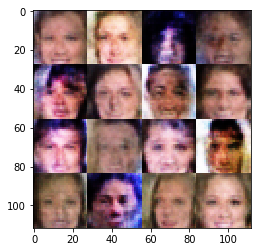

Epoch 0/1... Discriminator Loss: 1.0203... Generator Loss: 1.0958
Epoch 0/1... Discriminator Loss: 0.9976... Generator Loss: 1.5568
Epoch 0/1... Discriminator Loss: 0.8389... Generator Loss: 1.2641
Epoch 0/1... Discriminator Loss: 1.8506... Generator Loss: 0.2925
Epoch 0/1... Discriminator Loss: 1.2860... Generator Loss: 2.3311


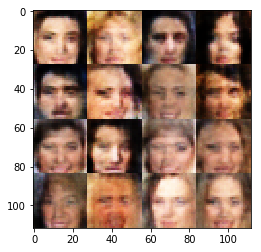

Epoch 0/1... Discriminator Loss: 1.0324... Generator Loss: 1.3320
Epoch 0/1... Discriminator Loss: 1.0084... Generator Loss: 1.3224
Epoch 0/1... Discriminator Loss: 1.6325... Generator Loss: 0.3744
Epoch 0/1... Discriminator Loss: 0.9798... Generator Loss: 0.9221
Epoch 0/1... Discriminator Loss: 1.1919... Generator Loss: 1.2977


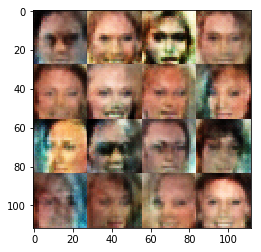

Epoch 0/1... Discriminator Loss: 0.8776... Generator Loss: 1.8184
Epoch 0/1... Discriminator Loss: 1.0451... Generator Loss: 1.1462
Epoch 0/1... Discriminator Loss: 0.9916... Generator Loss: 1.3482
Epoch 0/1... Discriminator Loss: 1.0548... Generator Loss: 1.0143
Epoch 0/1... Discriminator Loss: 0.9051... Generator Loss: 1.2812


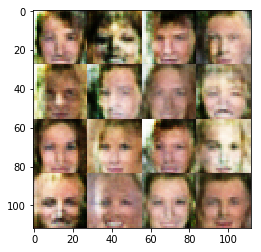

Epoch 0/1... Discriminator Loss: 1.1939... Generator Loss: 0.7594
Epoch 0/1... Discriminator Loss: 0.8829... Generator Loss: 1.2765
Epoch 0/1... Discriminator Loss: 1.0326... Generator Loss: 0.8623
Epoch 0/1... Discriminator Loss: 0.9514... Generator Loss: 1.0969
Epoch 0/1... Discriminator Loss: 0.8627... Generator Loss: 1.3291


Epoch 0/1... Discriminator Loss: 1.1125... Generator Loss: 0.9823
Epoch 0/1... Discriminator Loss: 1.2118... Generator Loss: 0.7340
Epoch 0/1... Discriminator Loss: 1.1705... Generator Loss: 0.9219
Epoch 0/1... Discriminator Loss: 0.8123... Generator Loss: 1.2865
Epoch 0/1... Discriminator Loss: 1.1089... Generator Loss: 0.8311


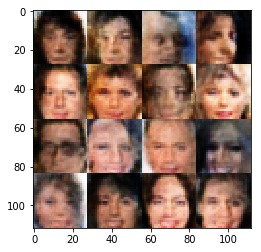

Epoch 0/1... Discriminator Loss: 0.8122... Generator Loss: 1.6546
Epoch 0/1... Discriminator Loss: 1.1323... Generator Loss: 0.8799
Epoch 0/1... Discriminator Loss: 1.4357... Generator Loss: 0.5023
Epoch 0/1... Discriminator Loss: 1.0655... Generator Loss: 1.2995
Epoch 0/1... Discriminator Loss: 1.0743... Generator Loss: 0.9470


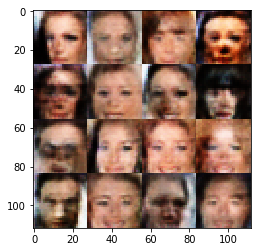

Epoch 0/1... Discriminator Loss: 0.9186... Generator Loss: 1.3402
Epoch 0/1... Discriminator Loss: 0.9924... Generator Loss: 1.5304
Epoch 0/1... Discriminator Loss: 1.2087... Generator Loss: 0.6871
Epoch 0/1... Discriminator Loss: 1.0857... Generator Loss: 0.9929
Epoch 0/1... Discriminator Loss: 1.1535... Generator Loss: 0.8176


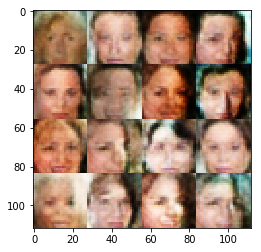

Epoch 0/1... Discriminator Loss: 1.0058... Generator Loss: 0.9674
Epoch 0/1... Discriminator Loss: 1.3421... Generator Loss: 0.7886
Epoch 0/1... Discriminator Loss: 1.2654... Generator Loss: 0.6661
Epoch 0/1... Discriminator Loss: 1.3360... Generator Loss: 0.5317
Epoch 0/1... Discriminator Loss: 1.3041... Generator Loss: 0.7132


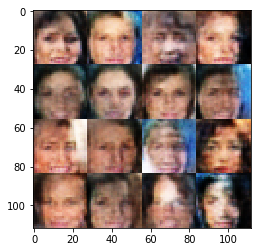

Epoch 0/1... Discriminator Loss: 1.0060... Generator Loss: 1.4645
Epoch 0/1... Discriminator Loss: 0.9870... Generator Loss: 1.1308
Epoch 0/1... Discriminator Loss: 1.3471... Generator Loss: 0.6502
Epoch 0/1... Discriminator Loss: 1.0425... Generator Loss: 0.8187
Epoch 0/1... Discriminator Loss: 1.0981... Generator Loss: 0.7981


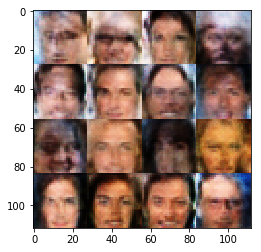

Epoch 0/1... Discriminator Loss: 0.7852... Generator Loss: 2.3201
Epoch 0/1... Discriminator Loss: 1.0390... Generator Loss: 1.4633
Epoch 0/1... Discriminator Loss: 1.3093... Generator Loss: 0.6407
Epoch 0/1... Discriminator Loss: 1.2059... Generator Loss: 0.6594
Epoch 0/1... Discriminator Loss: 0.9499... Generator Loss: 1.4473


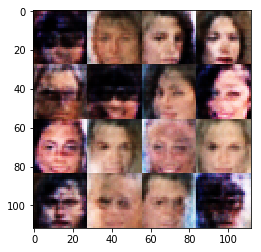

Epoch 0/1... Discriminator Loss: 1.1154... Generator Loss: 0.9004
Epoch 0/1... Discriminator Loss: 0.8757... Generator Loss: 1.3017
Epoch 0/1... Discriminator Loss: 0.8743... Generator Loss: 1.7008
Epoch 0/1... Discriminator Loss: 0.9344... Generator Loss: 0.9846
Epoch 0/1... Discriminator Loss: 1.1900... Generator Loss: 0.6994


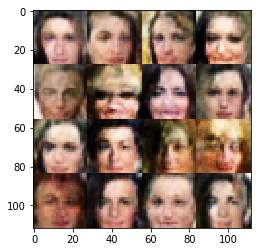

Epoch 0/1... Discriminator Loss: 1.1053... Generator Loss: 1.3474
Epoch 0/1... Discriminator Loss: 1.0019... Generator Loss: 1.3539
Epoch 0/1... Discriminator Loss: 0.8862... Generator Loss: 1.2818
Epoch 0/1... Discriminator Loss: 1.0963... Generator Loss: 1.2044
Epoch 0/1... Discriminator Loss: 1.5142... Generator Loss: 0.4338


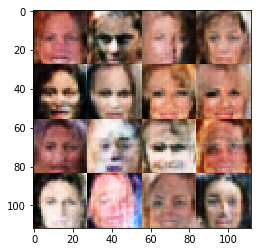

Epoch 0/1... Discriminator Loss: 1.0462... Generator Loss: 0.8973
Epoch 0/1... Discriminator Loss: 1.1233... Generator Loss: 0.8680
Epoch 0/1... Discriminator Loss: 1.1896... Generator Loss: 0.8195
Epoch 0/1... Discriminator Loss: 1.2456... Generator Loss: 0.6969
Epoch 0/1... Discriminator Loss: 1.2236... Generator Loss: 0.6501


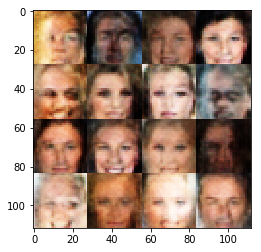

Epoch 0/1... Discriminator Loss: 1.0818... Generator Loss: 0.8955
Epoch 0/1... Discriminator Loss: 0.9984... Generator Loss: 1.0516
Epoch 0/1... Discriminator Loss: 1.3305... Generator Loss: 0.6269
Epoch 0/1... Discriminator Loss: 1.1091... Generator Loss: 1.0273
Epoch 0/1... Discriminator Loss: 1.3171... Generator Loss: 0.5817


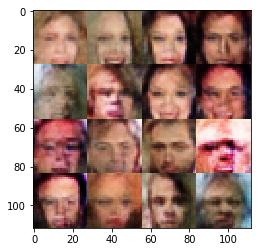

Epoch 0/1... Discriminator Loss: 1.3742... Generator Loss: 0.5508
Epoch 0/1... Discriminator Loss: 1.0214... Generator Loss: 0.9858
Epoch 0/1... Discriminator Loss: 1.3122... Generator Loss: 0.7740
Epoch 0/1... Discriminator Loss: 1.1097... Generator Loss: 0.7613
Epoch 0/1... Discriminator Loss: 1.1094... Generator Loss: 1.0798


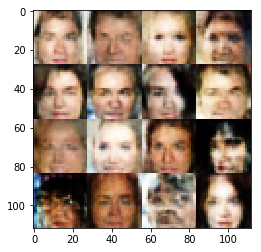

Epoch 0/1... Discriminator Loss: 0.9352... Generator Loss: 1.1616
Epoch 0/1... Discriminator Loss: 1.4087... Generator Loss: 0.5168
Epoch 0/1... Discriminator Loss: 1.0353... Generator Loss: 0.8437
Epoch 0/1... Discriminator Loss: 0.9161... Generator Loss: 1.1176
Epoch 0/1... Discriminator Loss: 1.0049... Generator Loss: 0.9542


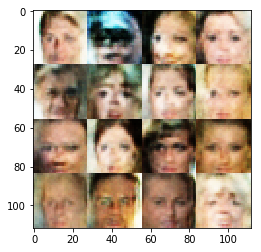

Epoch 0/1... Discriminator Loss: 1.5807... Generator Loss: 0.3878
Epoch 0/1... Discriminator Loss: 1.2246... Generator Loss: 1.1824
Epoch 0/1... Discriminator Loss: 0.7515... Generator Loss: 1.4589
Epoch 0/1... Discriminator Loss: 1.2008... Generator Loss: 0.7818
Epoch 0/1... Discriminator Loss: 0.9831... Generator Loss: 1.0865


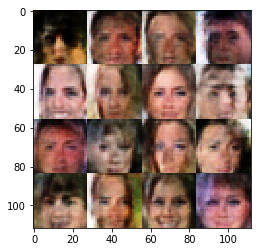

Epoch 0/1... Discriminator Loss: 0.9805... Generator Loss: 0.9983
Epoch 0/1... Discriminator Loss: 1.0965... Generator Loss: 1.0378
Epoch 0/1... Discriminator Loss: 1.0220... Generator Loss: 2.1954
Epoch 0/1... Discriminator Loss: 0.9417... Generator Loss: 1.8759
Epoch 0/1... Discriminator Loss: 0.9305... Generator Loss: 1.4632


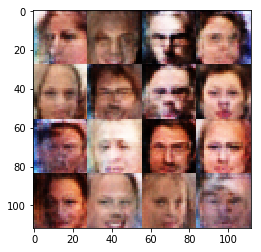

Epoch 0/1... Discriminator Loss: 1.1646... Generator Loss: 0.7054
Epoch 0/1... Discriminator Loss: 0.9958... Generator Loss: 1.3119
Epoch 0/1... Discriminator Loss: 1.4731... Generator Loss: 0.5075
Epoch 0/1... Discriminator Loss: 1.1000... Generator Loss: 1.0570
Epoch 0/1... Discriminator Loss: 1.0725... Generator Loss: 1.3988


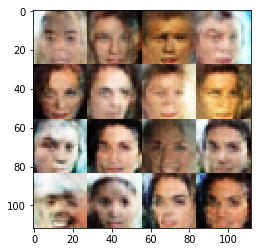

Epoch 0/1... Discriminator Loss: 1.4507... Generator Loss: 0.4898
Epoch 0/1... Discriminator Loss: 1.3715... Generator Loss: 0.5857
Epoch 0/1... Discriminator Loss: 0.8783... Generator Loss: 1.6754
Epoch 0/1... Discriminator Loss: 1.0907... Generator Loss: 0.8554
Epoch 0/1... Discriminator Loss: 0.7840... Generator Loss: 1.6061


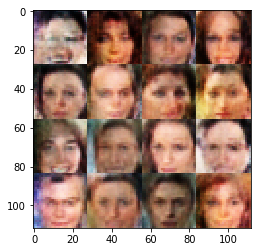

Epoch 0/1... Discriminator Loss: 1.0500... Generator Loss: 0.9134
Epoch 0/1... Discriminator Loss: 0.9891... Generator Loss: 2.1387
Epoch 0/1... Discriminator Loss: 1.2976... Generator Loss: 1.2283
Epoch 0/1... Discriminator Loss: 0.9931... Generator Loss: 1.3589
Epoch 0/1... Discriminator Loss: 1.6033... Generator Loss: 0.3730


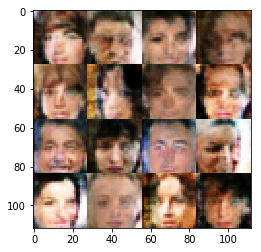

Epoch 0/1... Discriminator Loss: 0.7732... Generator Loss: 1.4929
Epoch 0/1... Discriminator Loss: 0.7317... Generator Loss: 1.8487
Epoch 0/1... Discriminator Loss: 1.0511... Generator Loss: 1.8004
Epoch 0/1... Discriminator Loss: 1.0124... Generator Loss: 1.4146
Epoch 0/1... Discriminator Loss: 1.2895... Generator Loss: 0.5766


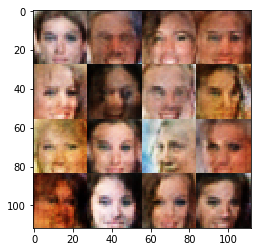

Epoch 0/1... Discriminator Loss: 0.9769... Generator Loss: 1.0702
Epoch 0/1... Discriminator Loss: 1.1393... Generator Loss: 0.8379
Epoch 0/1... Discriminator Loss: 1.0109... Generator Loss: 1.0457
Epoch 0/1... Discriminator Loss: 1.2681... Generator Loss: 0.6565
Epoch 0/1... Discriminator Loss: 1.0504... Generator Loss: 0.9474


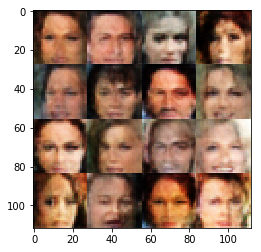

Epoch 0/1... Discriminator Loss: 1.1800... Generator Loss: 0.6940
Epoch 0/1... Discriminator Loss: 1.1813... Generator Loss: 1.1010
Epoch 0/1... Discriminator Loss: 0.7182... Generator Loss: 1.8059
Epoch 0/1... Discriminator Loss: 0.8727... Generator Loss: 1.1095
Epoch 0/1... Discriminator Loss: 0.9544... Generator Loss: 1.2007


Epoch 0/1... Discriminator Loss: 0.9787... Generator Loss: 1.0352
Epoch 0/1... Discriminator Loss: 1.0916... Generator Loss: 0.7766
Epoch 0/1... Discriminator Loss: 1.2564... Generator Loss: 0.6365
Epoch 0/1... Discriminator Loss: 0.9545... Generator Loss: 2.0242
Epoch 0/1... Discriminator Loss: 1.0370... Generator Loss: 0.9345


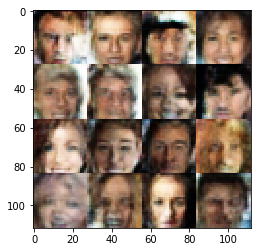

Epoch 0/1... Discriminator Loss: 1.3610... Generator Loss: 0.5468
Epoch 0/1... Discriminator Loss: 1.2733... Generator Loss: 0.5933
Epoch 0/1... Discriminator Loss: 1.1860... Generator Loss: 0.8150
Epoch 0/1... Discriminator Loss: 1.1843... Generator Loss: 0.7173
Epoch 0/1... Discriminator Loss: 0.9207... Generator Loss: 1.4753


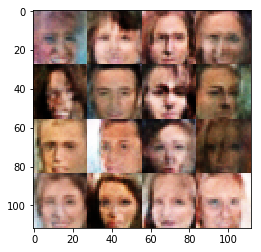

Epoch 0/1... Discriminator Loss: 1.0249... Generator Loss: 1.4128
Epoch 0/1... Discriminator Loss: 1.3293... Generator Loss: 0.6881
Epoch 0/1... Discriminator Loss: 1.0821... Generator Loss: 0.7134
Epoch 0/1... Discriminator Loss: 1.1045... Generator Loss: 1.0709
Epoch 0/1... Discriminator Loss: 0.8380... Generator Loss: 1.5186


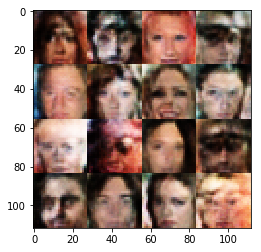

Epoch 0/1... Discriminator Loss: 1.0515... Generator Loss: 1.0682
Epoch 0/1... Discriminator Loss: 1.1011... Generator Loss: 0.8349
Epoch 0/1... Discriminator Loss: 1.0379... Generator Loss: 0.9513
Epoch 0/1... Discriminator Loss: 1.1690... Generator Loss: 1.3752
Epoch 0/1... Discriminator Loss: 1.1445... Generator Loss: 1.2697


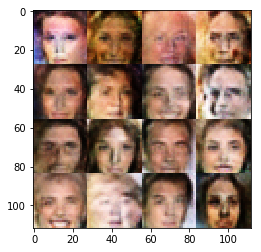

Epoch 0/1... Discriminator Loss: 1.0942... Generator Loss: 1.3853
Epoch 0/1... Discriminator Loss: 0.9599... Generator Loss: 1.3176
Epoch 0/1... Discriminator Loss: 0.8719... Generator Loss: 1.2079
Epoch 0/1... Discriminator Loss: 1.0763... Generator Loss: 1.2196
Epoch 0/1... Discriminator Loss: 1.1603... Generator Loss: 0.6952


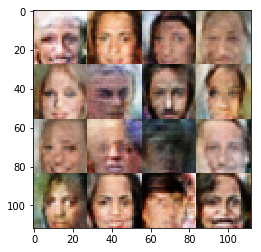

Epoch 0/1... Discriminator Loss: 1.1288... Generator Loss: 0.8214
Epoch 0/1... Discriminator Loss: 1.0064... Generator Loss: 1.2260
Epoch 0/1... Discriminator Loss: 1.1386... Generator Loss: 0.7361
Epoch 0/1... Discriminator Loss: 1.0555... Generator Loss: 1.5128
Epoch 0/1... Discriminator Loss: 1.3417... Generator Loss: 0.6996


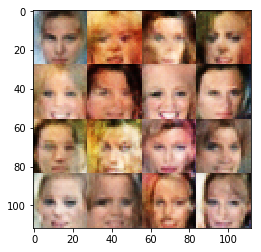

Epoch 0/1... Discriminator Loss: 0.8607... Generator Loss: 1.1785
Epoch 0/1... Discriminator Loss: 1.1737... Generator Loss: 0.6398
Epoch 0/1... Discriminator Loss: 0.9182... Generator Loss: 1.5823
Epoch 0/1... Discriminator Loss: 1.2036... Generator Loss: 0.6801
Epoch 0/1... Discriminator Loss: 0.8811... Generator Loss: 1.4008


Epoch 0/1... Discriminator Loss: 1.1266... Generator Loss: 0.7958
Epoch 0/1... Discriminator Loss: 0.8423... Generator Loss: 1.8395
Epoch 0/1... Discriminator Loss: 1.1795... Generator Loss: 0.6413
Epoch 0/1... Discriminator Loss: 0.9426... Generator Loss: 1.3823
Epoch 0/1... Discriminator Loss: 1.1754... Generator Loss: 0.7280


Epoch 0/1... Discriminator Loss: 0.7514... Generator Loss: 1.8013
Epoch 0/1... Discriminator Loss: 0.9498... Generator Loss: 1.0220
Epoch 0/1... Discriminator Loss: 1.3356... Generator Loss: 0.5836
Epoch 0/1... Discriminator Loss: 1.1560... Generator Loss: 0.7022
Epoch 0/1... Discriminator Loss: 1.2439... Generator Loss: 0.8485


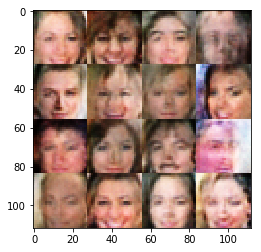

Epoch 0/1... Discriminator Loss: 0.9983... Generator Loss: 1.4136
Epoch 0/1... Discriminator Loss: 0.9600... Generator Loss: 1.3692
Epoch 0/1... Discriminator Loss: 1.2040... Generator Loss: 0.7520
Epoch 0/1... Discriminator Loss: 1.0823... Generator Loss: 0.9849
Epoch 0/1... Discriminator Loss: 0.9319... Generator Loss: 0.9607


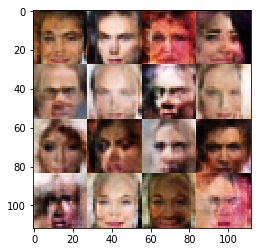

Epoch 0/1... Discriminator Loss: 1.2032... Generator Loss: 1.0600
Epoch 0/1... Discriminator Loss: 1.1091... Generator Loss: 1.0010
Epoch 0/1... Discriminator Loss: 1.0684... Generator Loss: 0.9973
Epoch 0/1... Discriminator Loss: 1.0779... Generator Loss: 1.0923
Epoch 0/1... Discriminator Loss: 0.8314... Generator Loss: 1.5519


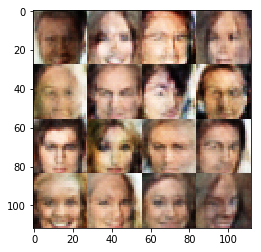

Epoch 0/1... Discriminator Loss: 1.2296... Generator Loss: 0.6468
Epoch 0/1... Discriminator Loss: 1.0088... Generator Loss: 1.2717
Epoch 0/1... Discriminator Loss: 1.0692... Generator Loss: 0.8778
Epoch 0/1... Discriminator Loss: 1.0656... Generator Loss: 0.9217
Epoch 0/1... Discriminator Loss: 1.3805... Generator Loss: 0.7879


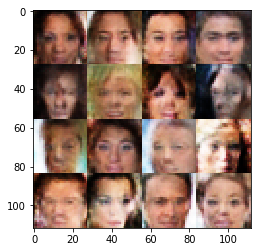

Epoch 0/1... Discriminator Loss: 1.1776... Generator Loss: 1.1093
Epoch 0/1... Discriminator Loss: 0.9226... Generator Loss: 1.4957
Epoch 0/1... Discriminator Loss: 1.0159... Generator Loss: 1.0167
Epoch 0/1... Discriminator Loss: 0.9965... Generator Loss: 0.9221
Epoch 0/1... Discriminator Loss: 1.3288... Generator Loss: 0.6354


Epoch 0/1... Discriminator Loss: 0.9736... Generator Loss: 1.0759
Epoch 0/1... Discriminator Loss: 0.7211... Generator Loss: 1.8130
Epoch 0/1... Discriminator Loss: 1.1241... Generator Loss: 0.7505
Epoch 0/1... Discriminator Loss: 1.1896... Generator Loss: 0.6808
Epoch 0/1... Discriminator Loss: 1.1220... Generator Loss: 1.2542


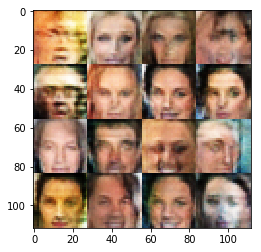

Epoch 0/1... Discriminator Loss: 1.1900... Generator Loss: 0.9613
Epoch 0/1... Discriminator Loss: 1.2418... Generator Loss: 0.8401
Epoch 0/1... Discriminator Loss: 0.8888... Generator Loss: 1.7488
Epoch 0/1... Discriminator Loss: 1.2692... Generator Loss: 1.8742
Epoch 0/1... Discriminator Loss: 0.8251... Generator Loss: 1.9461


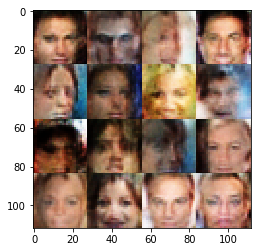

Epoch 0/1... Discriminator Loss: 0.9314... Generator Loss: 1.2280
Epoch 0/1... Discriminator Loss: 0.9174... Generator Loss: 1.6236
Epoch 0/1... Discriminator Loss: 0.9670... Generator Loss: 1.0168
Epoch 0/1... Discriminator Loss: 1.1717... Generator Loss: 0.7138
Epoch 0/1... Discriminator Loss: 1.1154... Generator Loss: 0.8202


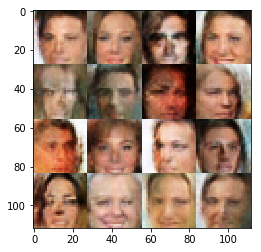

Epoch 0/1... Discriminator Loss: 0.8583... Generator Loss: 1.3047
Epoch 0/1... Discriminator Loss: 0.9970... Generator Loss: 1.0166
Epoch 0/1... Discriminator Loss: 1.1999... Generator Loss: 0.9489
Epoch 0/1... Discriminator Loss: 0.9148... Generator Loss: 1.2270
Epoch 0/1... Discriminator Loss: 1.0417... Generator Loss: 0.9788


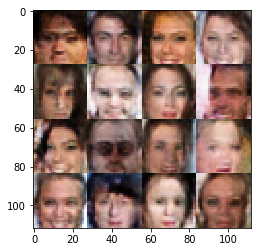

Epoch 0/1... Discriminator Loss: 1.2432... Generator Loss: 0.5935
Epoch 0/1... Discriminator Loss: 1.3524... Generator Loss: 0.7017
Epoch 0/1... Discriminator Loss: 1.1014... Generator Loss: 1.1900
Epoch 0/1... Discriminator Loss: 1.4073... Generator Loss: 0.5053
Epoch 0/1... Discriminator Loss: 1.0525... Generator Loss: 1.3743


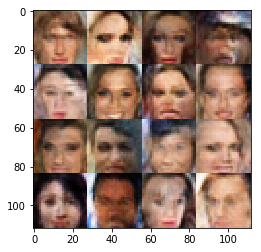

Epoch 0/1... Discriminator Loss: 1.0880... Generator Loss: 1.1323
Epoch 0/1... Discriminator Loss: 0.9496... Generator Loss: 1.2801
Epoch 0/1... Discriminator Loss: 1.0981... Generator Loss: 0.9557
Epoch 0/1... Discriminator Loss: 1.1065... Generator Loss: 0.7531
Epoch 0/1... Discriminator Loss: 0.9252... Generator Loss: 1.3811


Epoch 0/1... Discriminator Loss: 1.2728... Generator Loss: 0.6110
Epoch 0/1... Discriminator Loss: 1.3087... Generator Loss: 0.6055
Epoch 0/1... Discriminator Loss: 0.8443... Generator Loss: 1.6279
Epoch 0/1... Discriminator Loss: 1.1336... Generator Loss: 0.8667
Epoch 0/1... Discriminator Loss: 1.0633... Generator Loss: 0.8679


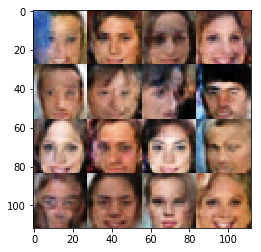

Epoch 0/1... Discriminator Loss: 1.0031... Generator Loss: 1.4786
Epoch 0/1... Discriminator Loss: 0.8837... Generator Loss: 1.3221
Epoch 0/1... Discriminator Loss: 1.2450... Generator Loss: 0.7269
Epoch 0/1... Discriminator Loss: 1.2284... Generator Loss: 0.7426
Epoch 0/1... Discriminator Loss: 1.0460... Generator Loss: 0.9754


Epoch 0/1... Discriminator Loss: 1.1552... Generator Loss: 0.9064
Epoch 0/1... Discriminator Loss: 0.9094... Generator Loss: 1.6900
Epoch 0/1... Discriminator Loss: 1.2770... Generator Loss: 0.6593
Epoch 0/1... Discriminator Loss: 1.2139... Generator Loss: 0.7996
Epoch 0/1... Discriminator Loss: 1.0468... Generator Loss: 0.9041


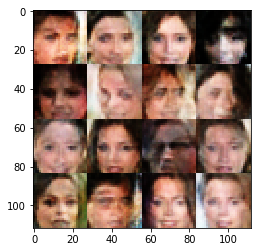

Epoch 0/1... Discriminator Loss: 1.0345... Generator Loss: 0.9171
Epoch 0/1... Discriminator Loss: 1.1045... Generator Loss: 1.0532
Epoch 0/1... Discriminator Loss: 1.1366... Generator Loss: 0.7077
Epoch 0/1... Discriminator Loss: 1.0123... Generator Loss: 0.9037
Epoch 0/1... Discriminator Loss: 1.1407... Generator Loss: 0.7470


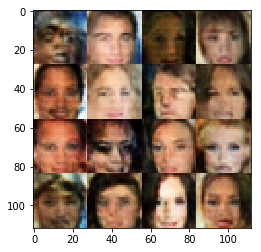

Epoch 0/1... Discriminator Loss: 1.0237... Generator Loss: 1.2381
Epoch 0/1... Discriminator Loss: 1.1393... Generator Loss: 0.9003
Epoch 0/1... Discriminator Loss: 0.8609... Generator Loss: 1.1733
Epoch 0/1... Discriminator Loss: 1.2537... Generator Loss: 1.0911
Epoch 0/1... Discriminator Loss: 1.2495... Generator Loss: 0.8721


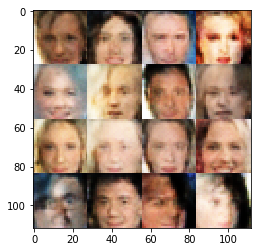

Epoch 0/1... Discriminator Loss: 1.2388... Generator Loss: 0.7197
Epoch 0/1... Discriminator Loss: 1.4875... Generator Loss: 0.5450
Epoch 0/1... Discriminator Loss: 1.3044... Generator Loss: 0.6363
Epoch 0/1... Discriminator Loss: 0.7999... Generator Loss: 1.5797
Epoch 0/1... Discriminator Loss: 1.0091... Generator Loss: 1.2027


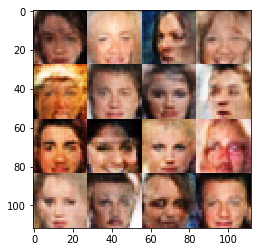

Epoch 0/1... Discriminator Loss: 1.1588... Generator Loss: 1.2933
Epoch 0/1... Discriminator Loss: 1.1773... Generator Loss: 0.6894
Epoch 0/1... Discriminator Loss: 1.3088... Generator Loss: 0.6817
Epoch 0/1... Discriminator Loss: 1.3325... Generator Loss: 0.5584
Epoch 0/1... Discriminator Loss: 0.9387... Generator Loss: 1.2828


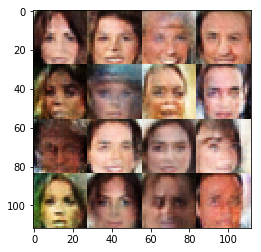

Epoch 0/1... Discriminator Loss: 1.2752... Generator Loss: 0.6348
Epoch 0/1... Discriminator Loss: 1.1200... Generator Loss: 1.3228
Epoch 0/1... Discriminator Loss: 1.1944... Generator Loss: 0.8586
Epoch 0/1... Discriminator Loss: 1.0377... Generator Loss: 1.2123
Epoch 0/1... Discriminator Loss: 1.0935... Generator Loss: 1.1996


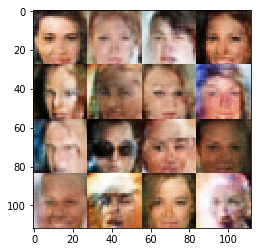

Epoch 0/1... Discriminator Loss: 1.3418... Generator Loss: 0.5467
Epoch 0/1... Discriminator Loss: 0.9972... Generator Loss: 0.9611
Epoch 0/1... Discriminator Loss: 0.9804... Generator Loss: 1.0943
Epoch 0/1... Discriminator Loss: 1.0365... Generator Loss: 1.0877
Epoch 0/1... Discriminator Loss: 0.9819... Generator Loss: 1.0848


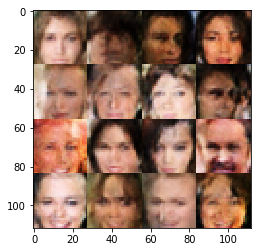

Epoch 0/1... Discriminator Loss: 1.2017... Generator Loss: 0.8545
Epoch 0/1... Discriminator Loss: 1.2427... Generator Loss: 0.9106
Epoch 0/1... Discriminator Loss: 1.6014... Generator Loss: 0.5072
Epoch 0/1... Discriminator Loss: 1.1999... Generator Loss: 1.0820
Epoch 0/1... Discriminator Loss: 1.0486... Generator Loss: 1.0649


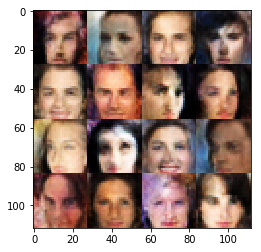

Epoch 0/1... Discriminator Loss: 0.7191... Generator Loss: 1.6799
Epoch 0/1... Discriminator Loss: 0.9717... Generator Loss: 0.9108
Epoch 0/1... Discriminator Loss: 1.2383... Generator Loss: 0.6908
Epoch 0/1... Discriminator Loss: 1.1599... Generator Loss: 0.7366
Epoch 0/1... Discriminator Loss: 1.1012... Generator Loss: 0.8603


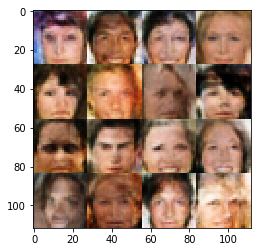

Epoch 0/1... Discriminator Loss: 1.0620... Generator Loss: 0.9074
Epoch 0/1... Discriminator Loss: 1.0643... Generator Loss: 1.0624
Epoch 0/1... Discriminator Loss: 1.0718... Generator Loss: 0.7669
Epoch 0/1... Discriminator Loss: 0.8070... Generator Loss: 1.4471
Epoch 0/1... Discriminator Loss: 1.1511... Generator Loss: 1.1537


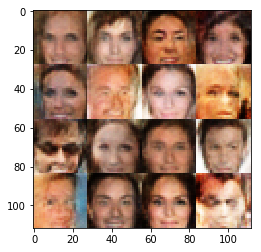

Epoch 0/1... Discriminator Loss: 1.2025... Generator Loss: 0.6567
Epoch 0/1... Discriminator Loss: 1.1926... Generator Loss: 0.6844
Epoch 0/1... Discriminator Loss: 1.2798... Generator Loss: 0.6367
Epoch 0/1... Discriminator Loss: 1.1775... Generator Loss: 0.7758
Epoch 0/1... Discriminator Loss: 1.1225... Generator Loss: 0.8037


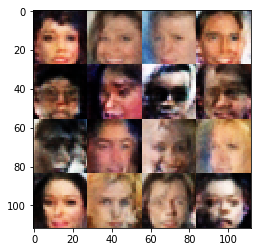

Epoch 0/1... Discriminator Loss: 1.2737... Generator Loss: 0.5966
Epoch 0/1... Discriminator Loss: 1.0235... Generator Loss: 1.0767
Epoch 0/1... Discriminator Loss: 1.0186... Generator Loss: 0.8728
Epoch 0/1... Discriminator Loss: 0.9996... Generator Loss: 0.9989
Epoch 0/1... Discriminator Loss: 1.4530... Generator Loss: 0.4740


Epoch 0/1... Discriminator Loss: 1.0436... Generator Loss: 1.0515
Epoch 0/1... Discriminator Loss: 1.3060... Generator Loss: 0.6661
Epoch 0/1... Discriminator Loss: 1.3252... Generator Loss: 0.5777
Epoch 0/1... Discriminator Loss: 1.3376... Generator Loss: 0.7709
Epoch 0/1... Discriminator Loss: 1.2810... Generator Loss: 0.6014


Epoch 0/1... Discriminator Loss: 1.3083... Generator Loss: 0.5697
Epoch 0/1... Discriminator Loss: 1.2666... Generator Loss: 0.6910
Epoch 0/1... Discriminator Loss: 1.2606... Generator Loss: 0.6837
Epoch 0/1... Discriminator Loss: 1.0952... Generator Loss: 1.2466
Epoch 0/1... Discriminator Loss: 1.4140... Generator Loss: 0.5856


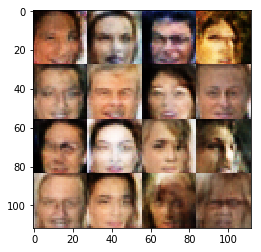

Epoch 0/1... Discriminator Loss: 1.1160... Generator Loss: 0.9253
Epoch 0/1... Discriminator Loss: 0.9271... Generator Loss: 1.2501
Epoch 0/1... Discriminator Loss: 1.0887... Generator Loss: 1.1009
Epoch 0/1... Discriminator Loss: 1.2509... Generator Loss: 0.6629
Epoch 0/1... Discriminator Loss: 0.9735... Generator Loss: 1.3268


Epoch 0/1... Discriminator Loss: 1.0162... Generator Loss: 1.1260
Epoch 0/1... Discriminator Loss: 0.8933... Generator Loss: 1.3793
Epoch 0/1... Discriminator Loss: 1.0152... Generator Loss: 0.9269
Epoch 0/1... Discriminator Loss: 1.2764... Generator Loss: 0.8072
Epoch 0/1... Discriminator Loss: 1.2857... Generator Loss: 0.5763


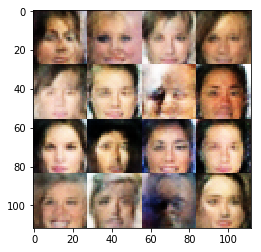

Epoch 0/1... Discriminator Loss: 1.0215... Generator Loss: 1.0992
Epoch 0/1... Discriminator Loss: 1.0984... Generator Loss: 0.8066
Epoch 0/1... Discriminator Loss: 1.2499... Generator Loss: 0.9340
Epoch 0/1... Discriminator Loss: 0.9411... Generator Loss: 1.0141
Epoch 0/1... Discriminator Loss: 1.0866... Generator Loss: 1.0913


Epoch 0/1... Discriminator Loss: 1.0425... Generator Loss: 0.9864
Epoch 0/1... Discriminator Loss: 1.1965... Generator Loss: 0.6601
Epoch 0/1... Discriminator Loss: 1.1450... Generator Loss: 0.8114
Epoch 0/1... Discriminator Loss: 0.8833... Generator Loss: 1.3937
Epoch 0/1... Discriminator Loss: 0.8627... Generator Loss: 1.1137


Epoch 0/1... Discriminator Loss: 1.3006... Generator Loss: 0.7697
Epoch 0/1... Discriminator Loss: 0.8266... Generator Loss: 1.2332
Epoch 0/1... Discriminator Loss: 1.0230... Generator Loss: 1.2214
Epoch 0/1... Discriminator Loss: 1.1746... Generator Loss: 0.8724
Epoch 0/1... Discriminator Loss: 1.3754... Generator Loss: 0.6319


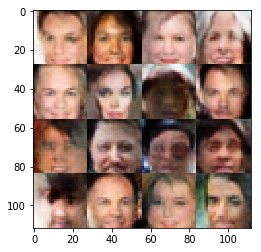

Epoch 0/1... Discriminator Loss: 0.7014... Generator Loss: 1.8151
Epoch 0/1... Discriminator Loss: 1.0383... Generator Loss: 0.9914
Epoch 0/1... Discriminator Loss: 1.0907... Generator Loss: 1.0255
Epoch 0/1... Discriminator Loss: 1.2094... Generator Loss: 0.7353
Epoch 0/1... Discriminator Loss: 1.0942... Generator Loss: 1.1245


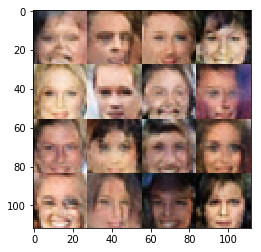

Epoch 0/1... Discriminator Loss: 0.9780... Generator Loss: 0.9054
Epoch 0/1... Discriminator Loss: 1.1445... Generator Loss: 1.0857
Epoch 0/1... Discriminator Loss: 1.0672... Generator Loss: 0.7926
Epoch 0/1... Discriminator Loss: 1.1949... Generator Loss: 0.8482
Epoch 0/1... Discriminator Loss: 1.5404... Generator Loss: 0.4053


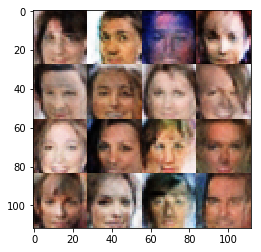

Epoch 0/1... Discriminator Loss: 1.3713... Generator Loss: 0.5889
Epoch 0/1... Discriminator Loss: 1.4288... Generator Loss: 0.4700
Epoch 0/1... Discriminator Loss: 0.9935... Generator Loss: 1.0340
Epoch 0/1... Discriminator Loss: 1.2981... Generator Loss: 0.7806
Epoch 0/1... Discriminator Loss: 1.0012... Generator Loss: 1.1029


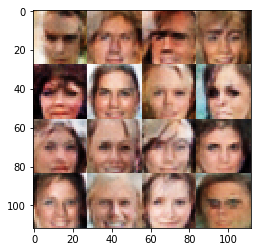

Epoch 0/1... Discriminator Loss: 1.0797... Generator Loss: 1.2893
Epoch 0/1... Discriminator Loss: 0.8969... Generator Loss: 1.2568
Epoch 0/1... Discriminator Loss: 1.0960... Generator Loss: 0.8819
Epoch 0/1... Discriminator Loss: 0.7745... Generator Loss: 1.3784
Epoch 0/1... Discriminator Loss: 1.2792... Generator Loss: 0.6982


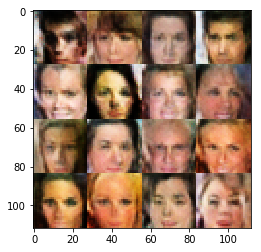

Epoch 0/1... Discriminator Loss: 0.9364... Generator Loss: 1.1467
Epoch 0/1... Discriminator Loss: 1.2522... Generator Loss: 0.6788
Epoch 0/1... Discriminator Loss: 1.4999... Generator Loss: 0.4386
Epoch 0/1... Discriminator Loss: 1.1316... Generator Loss: 0.7951
Epoch 0/1... Discriminator Loss: 1.2246... Generator Loss: 1.4122


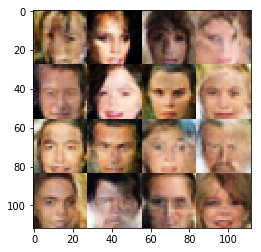

Epoch 0/1... Discriminator Loss: 0.9997... Generator Loss: 1.2385
Epoch 0/1... Discriminator Loss: 1.3477... Generator Loss: 0.5401
Epoch 0/1... Discriminator Loss: 1.0726... Generator Loss: 1.0160
Epoch 0/1... Discriminator Loss: 1.2178... Generator Loss: 0.6052
Epoch 0/1... Discriminator Loss: 1.3735... Generator Loss: 0.5535


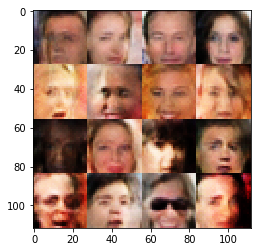

Epoch 0/1... Discriminator Loss: 1.0482... Generator Loss: 0.8670
Epoch 0/1... Discriminator Loss: 0.8593... Generator Loss: 1.4458
Epoch 0/1... Discriminator Loss: 1.1806... Generator Loss: 0.8765
Epoch 0/1... Discriminator Loss: 1.2562... Generator Loss: 0.7514
Epoch 0/1... Discriminator Loss: 1.2380... Generator Loss: 1.1574


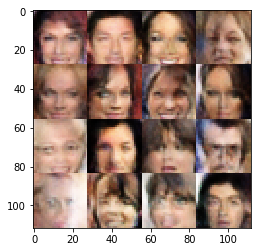

Epoch 0/1... Discriminator Loss: 0.9205... Generator Loss: 1.1762
Epoch 0/1... Discriminator Loss: 0.9470... Generator Loss: 1.1092
Epoch 0/1... Discriminator Loss: 0.8308... Generator Loss: 1.7282
Epoch 0/1... Discriminator Loss: 0.7881... Generator Loss: 1.5388
Epoch 0/1... Discriminator Loss: 0.9689... Generator Loss: 1.0981


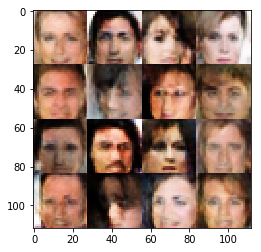

Epoch 0/1... Discriminator Loss: 1.1343... Generator Loss: 0.6921
Epoch 0/1... Discriminator Loss: 1.0575... Generator Loss: 0.8377
Epoch 0/1... Discriminator Loss: 1.1534... Generator Loss: 0.7867
Epoch 0/1... Discriminator Loss: 1.1656... Generator Loss: 0.9869
Epoch 0/1... Discriminator Loss: 1.1723... Generator Loss: 0.9982


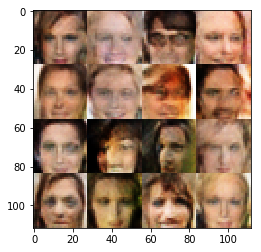

Epoch 0/1... Discriminator Loss: 1.1459... Generator Loss: 0.7498
Epoch 0/1... Discriminator Loss: 0.9677... Generator Loss: 1.3872
Epoch 0/1... Discriminator Loss: 1.3044... Generator Loss: 1.0703
Epoch 0/1... Discriminator Loss: 0.9804... Generator Loss: 1.3086
Epoch 0/1... Discriminator Loss: 1.1728... Generator Loss: 1.0304


Epoch 0/1... Discriminator Loss: 1.0319... Generator Loss: 1.0937
Epoch 0/1... Discriminator Loss: 1.0424... Generator Loss: 0.8033
Epoch 0/1... Discriminator Loss: 1.1080... Generator Loss: 0.8825
Epoch 0/1... Discriminator Loss: 0.9786... Generator Loss: 1.2847
Epoch 0/1... Discriminator Loss: 1.1452... Generator Loss: 0.8468


Epoch 0/1... Discriminator Loss: 1.0467... Generator Loss: 0.9166
Epoch 0/1... Discriminator Loss: 1.0095... Generator Loss: 1.0382
Epoch 0/1... Discriminator Loss: 1.0563... Generator Loss: 1.0644
Epoch 0/1... Discriminator Loss: 1.0617... Generator Loss: 0.9897
Epoch 0/1... Discriminator Loss: 1.3137... Generator Loss: 0.6614


Epoch 0/1... Discriminator Loss: 1.1829... Generator Loss: 0.7254
Epoch 0/1... Discriminator Loss: 1.2130... Generator Loss: 0.6642
Epoch 0/1... Discriminator Loss: 1.1321... Generator Loss: 0.7211
Epoch 0/1... Discriminator Loss: 1.0695... Generator Loss: 0.9219


In [18]:
batch_size = 32
z_dim = 128
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.